In [1]:

%pip install openreview-py -i https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip show openreview

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scipy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simpleNote: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/45.9 MB ? eta -:--:--
      --------------------------------------- 1.0/45.9 MB 32.7 MB/s eta 0:00:02
     --- ------------------------------------ 3.7/45.9 MB 47.8 MB/s eta 0:00:01
     ----- ---------------------------------- 5.8/45.9 MB 61.3 MB/s eta 0:00:01
     ----- ---------------------------------- 6.0/45.9 MB 38.5 MB/s eta 0:00:02
     ----- ---------------------------------- 6.3/45.9 MB 28.5 MB/s eta 0:00:02
     ----- ---------------------------------- 6.3/45.9 MB 27.0 MB/s eta 0:00:02
     ----- ---------------------------------- 6.5/45.9 MB 21.8 MB/s eta 0:00:02
     ------ --------------------------------- 7.3/45.9 MB 20.3 MB/s eta 0:00:02
     ------ --------------------------------- 7.4/45.9 MB 18.3 MB/s eta 0:00:03
     ------ --------------------------------- 8.0/45.9 MB 19.0 MB/s eta 0:00:02
 

In [1]:

import openreview
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from scipy.stats import norm
from collections import Counter
import collections
import itertools
from math import comb
import json
from datetime import datetime
import math
from math import factorial

In [2]:
print(dir(openreview))


['Agora', 'AuthorReorder', 'BidStage', 'Client', 'CommentStage', 'Conference', 'ConferenceBuilder', 'CustomStage', 'DecisionStage', 'Edge', 'Empty', 'Enum', 'EthicsReviewStage', 'ExpertiseSelectionStage', 'Group', 'HTTPAdapter', 'IdentityReaders', 'Invitation', 'LogRetry', 'MetaReviewRevisionStage', 'MetaReviewStage', 'Note', 'OpenReviewException', 'Profile', 'ProfileManagement', 'RegistrationStage', 'Retry', 'ReviewRatingStage', 'ReviewRebuttalStage', 'ReviewRevisionStage', 'ReviewStage', 'SHORT_BUFFER_MIN', 'StringIO', 'SubmissionRevisionStage', 'SubmissionStage', 'Tag', 'ThreadPoolExecutor', 'VenueRequest', 'VenueStages', 'WebfieldBuilder', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'absolute_import', 'agora', 'api', 'argparse', 'arr', 'builder', 'concurrent', 'conference', 'cpu_count', 'csv', 'datetime', 'default_content', 'defaultdict', 'deprecated', 'division', 'get_bid_stages', 'get_comment_stage', 'get_c

In [3]:
"""
Load the data
"""
def extract_number(string):
    colon_index = string.find(":")
    if colon_index != -1:
        number_str = string[:colon_index].strip()
        if number_str.isdigit():
            return int(number_str)

client = openreview.Client(baseurl='https://api.openreview.net')

    
submissions = client.get_all_notes(
    invitation="ICLR.cc/2023/Conference/-/Blind_Submission",
    details='directReplies'
)

papers = [] 
# for submission in submissions:
#     authorids = submission.content['authorids']
#     scores = []
#     for reply in submission.details["directReplies"]:
#         print(reply)
#         if reply["invitation"].endswith("Decision"):
#             forum = reply['forum']
#             decision = reply['content']['decision']
#         if reply["invitation"].endswith("Official_Review"):
#             score = extract_number(reply['content']['rating'])
#             scores += [score]
#         if reply['id'] == 'MXV1TACjo_':
#             print()
#     review = {'forum': forum, 'authorids': authorids, 'decision': decision, 'scores': scores}
#     papers.append(review)
    
    
    
with open('papers_2021.json', 'r') as file:
    papers = json.load(file)
papers[0]

Getting V1 Notes: 100%|██████████████████████████████████████████████████████████▉| 3794/3798 [00:09<00:00, 397.89it/s]


{'forum': 'trPMYEn1FCX',
 'authorids': ['ucabab6@ucl.ac.uk',
  'rrg27@cam.ac.uk',
  'r.gray@ucl.ac.uk',
  'ashwani.jha@ucl.ac.uk',
  'p.nachev@ucl.ac.uk'],
 'decision': 'Reject',
 'scores': [3, 4, 5, 5]}

In [4]:
"""
Some tool functions
"""

def count_scores_by_length(lst, k):
    counts = {}
    for item in lst:
        scores = item.get('scores', [])
        if len(scores) == k:
            counts[k] = counts.get(k, 0) + 1
    return counts

def count_keys_with_value(dictionary, v):
    count = 0
    for value in dictionary.values():
        if value == v:
            count += 1
    return count

def get_keys_with_value(dictionary, v):
    keys_with_value = []
    for key, value in dictionary.items():
        if value == v:
            keys_with_value.append(key)
    return keys_with_value

count_scores_by_length(papers, 3)

{3: 520}

mean score = 5.51073217726397 
std of score = 1.0093838772209565


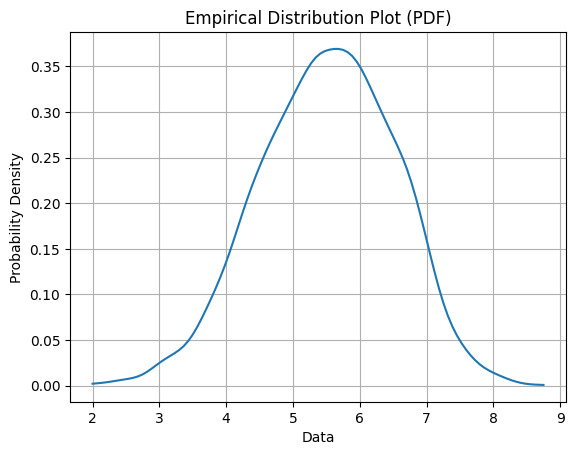

In [5]:
# learn the prior of paper quality. See Appendix C for the detials of the model

n = len(papers)
score_list_avg = np.zeros(n)
for i in range(n):
    score_list_avg[i] = np.average(papers[i]['scores'])
    
mu_q = np.average(score_list_avg)
sig_q = np.std(score_list_avg)
print('mean score =', mu_q, '\nstd of score =', sig_q)

def plot_empirical_distribution(data):
    # Estimate the probability density function (PDF)
    kde = gaussian_kde(data)

    # Generate a range of values for x-axis
    x = np.linspace(min(data), max(data), 100)

    # Evaluate the PDF at the given x values
    pdf = kde.evaluate(x)

    # Plot the empirical distribution
    plt.plot(x, pdf)
    plt.xlabel('Data')
    plt.ylabel('Probability Density')
    plt.title('Empirical Distribution Plot (PDF)')
    plt.grid(True)
    plt.show()
    
plot_empirical_distribution(score_list_avg)

Fitted t: -0.513295875088361


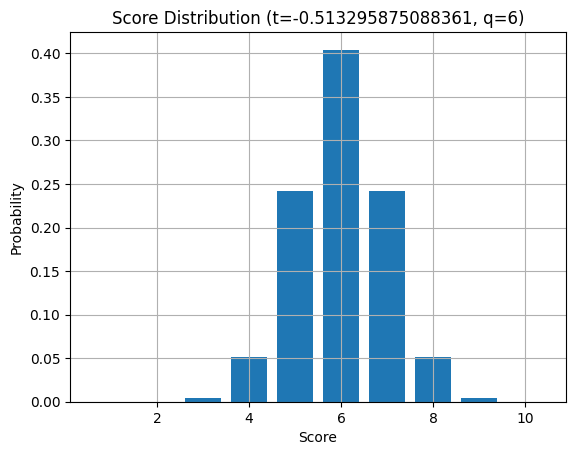

In [6]:
# learn the review noise

def fit_parameter_t(data):
    # Define the log-likelihood function
    def log_likelihood(t):
        log_likelihood_val = 0

        for entry in data:
            scores = np.array(entry)
            q = np.mean(scores)
            log_denominator = np.log(np.sum(np.exp(t * (np.arange(1, 11) - q)**2)))
            log_likelihood_val += np.sum(t * (scores - q)**2 - log_denominator)

        return -log_likelihood_val

    # Initial guess for parameter t
    initial_t = 1.0

    # Minimize the negative log-likelihood to estimate t
    result = minimize(log_likelihood, initial_t, method='BFGS')

    fitted_t = result.x[0]
    return fitted_t

n = len(papers)
score_list = []
for i in range(n):
    score_list.append(papers[i]['scores'])

t = fit_parameter_t(score_list)
print("Fitted t:", t)

def plot_score_distribution(t, q):
    scores = np.arange(1, 11)
    probabilities = np.exp(t * (scores - q)**2) / np.sum(np.exp(t * (scores - q)**2))

    plt.bar(scores, probabilities)
    plt.xlabel('Score')
    plt.ylabel('Probability')
    plt.title('Score Distribution (t={}, q={})'.format(t, q))
    plt.grid(True)
    plt.show()
    
plot_score_distribution(t, 6)

In [7]:
# learn the prior of number of papers each author has
# Assign papers to the author with the most papers

def find_most_common_string(dictionary):
    string_counts = {}

    for values in dictionary.values():
        for string in values:
            string_counts[string] = string_counts.get(string, 0) + 1

    most_common_string = max(string_counts, key=string_counts.get)
    return most_common_string, string_counts[most_common_string]


def assign_authors_to_papers(paper_dict):
    assigned_papers = {}
    
    while paper_dict:
        author_max, count = find_most_common_string(paper_dict)
        if count == 1:
            for key, values in paper_dict.items():
                assigned_papers[key] = values[0]
            return assigned_papers

        papers_to_remove = []
        for key, values in paper_dict.items():
            if any(author_max in value for value in values):
                papers_to_remove.append(key)
                assigned_papers[key] = author_max

        for paper in papers_to_remove:
            del paper_dict[paper]


paper_author_map = {}
n = len(papers)
score_list = []
for i in range(n):
    paper_author_map[papers[i]['forum']] = papers[i]['authorids']

assigned_papers = assign_authors_to_papers(paper_author_map)

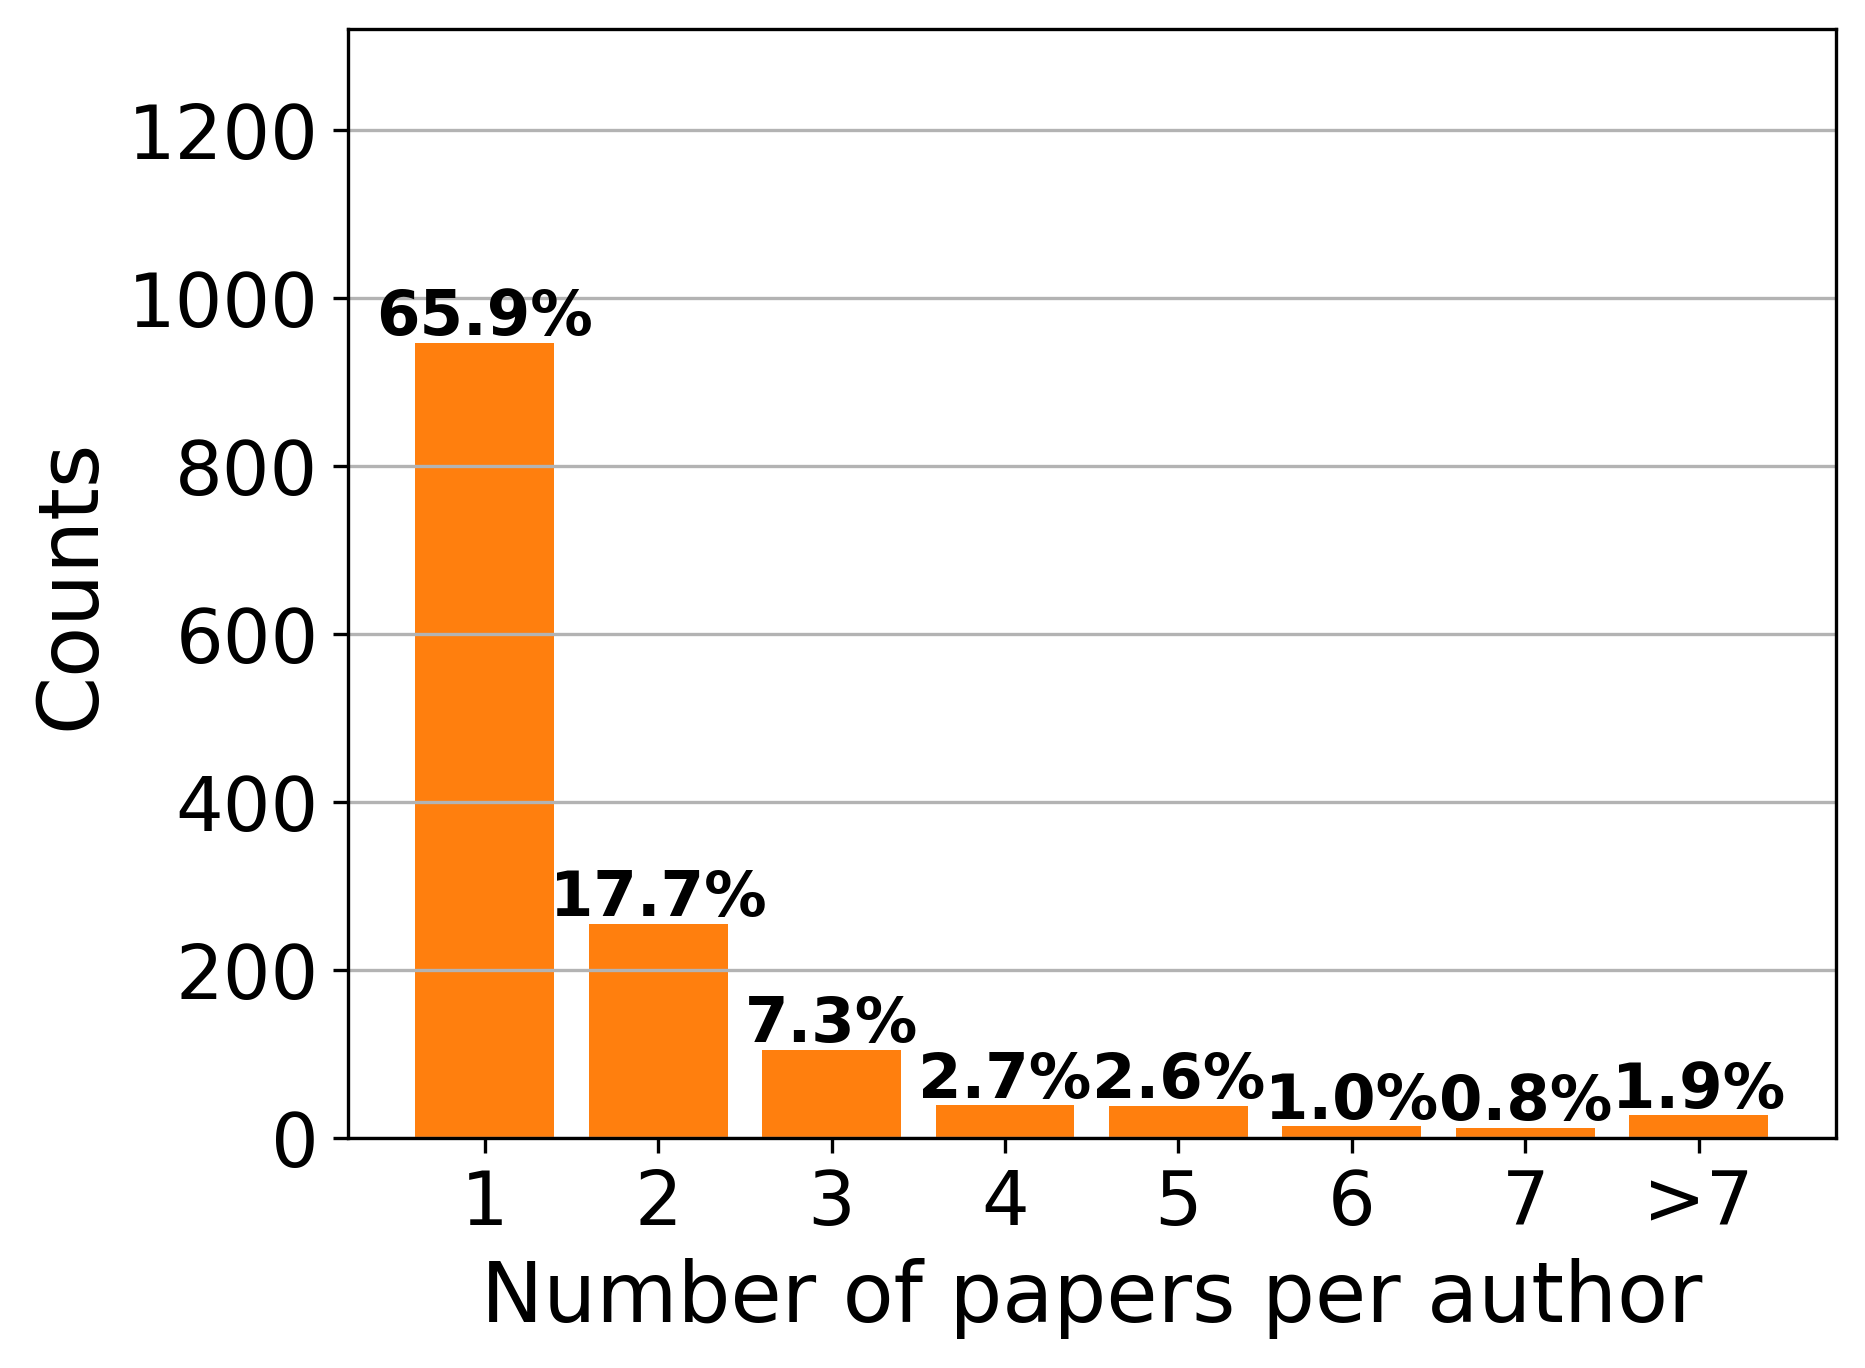

In [8]:
"Visualize the distirbution of the number of papers each author has"

def plot_author_paper_distribution(paper_dict):
    author_paper_counts = {}

    # Count the number of papers for each author
    for author in paper_dict.values():
        author_paper_counts[author] = author_paper_counts.get(author, 0) + 1

    # Count the number of authors for each number of papers
    paper_counts = {}
    for count in author_paper_counts.values():
        if count <= 7:
            paper_counts[str(count)] = paper_counts.get(str(count), 0) + 1
        else:
            paper_counts['>7'] = paper_counts.get('>7', 0) + 1

    # Create the plot
    x = list(paper_counts.keys())[::-1]
    y = list(paper_counts.values())[::-1]

    fig, ax = plt.subplots(dpi = 300)
    plt.rcParams['figure.figsize'] = (8, 5)
    
    bars = ax.bar(
    x=x,
    height = y
    )
    
    plt.bar(x, y)
    plt.xlabel("Number of papers per author", fontsize = '20')
    plt.ylabel("Counts", fontsize = '20')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax.yaxis.grid(True, color='#B3B3B3')
    ax.xaxis.grid(False)
    plt.ylim(0,1320)
    
    for i,bar in enumerate(bars):
        ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 10,
          str(np.round(y[i]/sum(y)*100, 1))+'%',
            fontsize = 15,
          horizontalalignment='center',
          color='black',
          weight='bold'
          )
    
def calculate_author_paper_distribution(paper_dict):
    author_paper_counts = {}

    # Count the number of papers for each author
    for author in paper_dict.values():
        author_paper_counts[author] = author_paper_counts.get(author, 0) + 1

    # Count the number of authors for each number of papers
    paper_counts = {}
    for count in author_paper_counts.values():
        paper_counts[count] = paper_counts.get(count, 0) + 1

    tmp = np.array(sorted(paper_counts.items()))
    N = np.sum(tmp[:, 1])
    frequency = tmp[:, 1] / N
    output = np.column_stack((tmp, frequency))
    output[:,:2] = output[:,:2].astype(int)
    return output

number_of_paper_frequency = calculate_author_paper_distribution(assigned_papers)
plot_author_paper_distribution(assigned_papers)
# print(number_of_paper_frequency, np.sum(number_of_paper_frequency[:,0]*number_of_paper_frequency[:,2]))

## The Softmax Review Model and the Mechanisms

In [9]:
"""
Define the model
"""

class RealConfParams:
    def __init__(self, n, k, mu_q, sig_q, t):
        self.n = n            # number of papers
        self.k = k            # number of reviews
        self.mu_q = mu_q      # mean of quality prior
        self.sig_q = sig_q    # std of quality prior
        self.t = t            # temperature of review noise
        
        
# draw samples from quality distribution
def sample_q(para, nmc):
    samples = np.random.normal(loc=para.mu_q, scale=para.sig_q, size=(nmc,para.n))
    return np.sort(samples, axis = 1, kind='quicksort')[:,::-1]

n = 10
k = 3

para = RealConfParams(
        n = n,
        k = k,
        mu_q = mu_q,
        sig_q = sig_q,
        t = t
        )

q_samples = sample_q(para, 1000)

In [10]:
"""
Compute possible thresholds
"""

def MAP_estimator_q(para, signals):
    t = para.t
    mu_q = para.mu_q
    sig_q = para.sig_q
    
    def log_MAP(q):
        log_prior = np.log(norm.pdf(q,mu_q, sig_q))
        sigs = np.array(signals)
        log_MAP_val = np.sum(t * (sigs - q)**2)+ log_prior

        return -log_MAP_val
    
    initial_q = 5

    # Minimize the negative log-likelihood to estimate t
    result = minimize(log_MAP, initial_q, method='BFGS')
    fitted_q = result.x[0]
    return fitted_q

global possible_thresholds
possible_thresholds = {}
for combination in itertools.combinations_with_replacement(range(1, 11), k):
    sorted_combination = tuple(sorted(combination))
    possible_thresholds[sorted_combination] = MAP_estimator_q(para, combination)
possible_thresholds = dict(sorted(possible_thresholds.items(), key = lambda item: item[1]))
print(possible_thresholds)

{(1, 1, 1): 2.0901159452847833, (1, 1, 2): 2.3428919964541914, (1, 2, 2): 2.595668051146512, (1, 1, 3): 2.5956680623160064, (2, 2, 2): 2.8484440765181973, (1, 2, 3): 2.848444201575678, (1, 1, 4): 2.8484442053989656, (1, 3, 3): 3.1012202692310438, (1, 1, 5): 3.101220293299395, (2, 2, 3): 3.101220296822312, (1, 2, 4): 3.101220322652118, (2, 3, 3): 3.353996430679521, (1, 1, 6): 3.353996443728561, (1, 3, 4): 3.3539964491631227, (2, 2, 4): 3.3539964491631227, (1, 2, 5): 3.353996473081284, (1, 4, 4): 3.606772594157727, (3, 3, 3): 3.606772594157727, (1, 3, 5): 3.606772603265392, (2, 2, 5): 3.606772603265392, (2, 3, 4): 3.606772623510451, (1, 2, 6): 3.606772634647843, (1, 1, 7): 3.6067726751379596, (2, 3, 5): 3.859548740795705, (2, 4, 4): 3.859548740795705, (1, 2, 7): 3.8595487407957054, (1, 1, 8): 3.859548744586893, (1, 3, 6): 3.859548744586893, (1, 4, 5): 3.859548744586893, (2, 2, 6): 3.859548744586893, (3, 3, 4): 3.859548744586893, (3, 3, 5): 4.112324885011614, (1, 4, 6): 4.11232489146104, 

In [11]:
def acceptance_probability(para, q, t_acc):
    t = para.t
    k = para.k
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    
    scores = np.arange(1, 11)
    q_reshape = q[np.newaxis, :]
    # print(q_reshape.shape)
    for combination in itertools.product(range(1, 11), repeat=k):
        sorted_combination = tuple(sorted(combination))
        estimated_q = possible_thresholds[sorted_combination]
        if estimated_q >= t_acc:
            prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0)
            acc_probability += np.prod(prob, axis = 0)
            # print(acc_probability.shape)
            
    return acc_probability

def parallel_quality_discrete(para, q, t_acc):
    nmc = np.size(q, axis = 0)
    n = para.n
    t = para.t
    
    q_acc = np.zeros(nmc)
    for i in range(n):
        p_acc = acceptance_probability(para, q[:,i], t_acc)
        q_acc += p_acc*(q[:,i] - 5.5)
    return (np.average(q_acc), np.var(q_acc))

parallel_quality_discrete(para, q_samples, 5.6)

(3.5377208642538127, 3.6370364618176585)

In [14]:
for combination in itertools.product(range(1, 11), repeat=3):
    print (combination)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 1, 5)
(1, 1, 6)
(1, 1, 7)
(1, 1, 8)
(1, 1, 9)
(1, 1, 10)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 2, 7)
(1, 2, 8)
(1, 2, 9)
(1, 2, 10)
(1, 3, 1)
(1, 3, 2)
(1, 3, 3)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 3, 7)
(1, 3, 8)
(1, 3, 9)
(1, 3, 10)
(1, 4, 1)
(1, 4, 2)
(1, 4, 3)
(1, 4, 4)
(1, 4, 5)
(1, 4, 6)
(1, 4, 7)
(1, 4, 8)
(1, 4, 9)
(1, 4, 10)
(1, 5, 1)
(1, 5, 2)
(1, 5, 3)
(1, 5, 4)
(1, 5, 5)
(1, 5, 6)
(1, 5, 7)
(1, 5, 8)
(1, 5, 9)
(1, 5, 10)
(1, 6, 1)
(1, 6, 2)
(1, 6, 3)
(1, 6, 4)
(1, 6, 5)
(1, 6, 6)
(1, 6, 7)
(1, 6, 8)
(1, 6, 9)
(1, 6, 10)
(1, 7, 1)
(1, 7, 2)
(1, 7, 3)
(1, 7, 4)
(1, 7, 5)
(1, 7, 6)
(1, 7, 7)
(1, 7, 8)
(1, 7, 9)
(1, 7, 10)
(1, 8, 1)
(1, 8, 2)
(1, 8, 3)
(1, 8, 4)
(1, 8, 5)
(1, 8, 6)
(1, 8, 7)
(1, 8, 8)
(1, 8, 9)
(1, 8, 10)
(1, 9, 1)
(1, 9, 2)
(1, 9, 3)
(1, 9, 4)
(1, 9, 5)
(1, 9, 6)
(1, 9, 7)
(1, 9, 8)
(1, 9, 9)
(1, 9, 10)
(1, 10, 1)
(1, 10, 2)
(1, 10, 3)
(1, 10, 4)
(1, 10, 5)
(1, 10, 6)
(1, 10, 7)
(1, 10, 8)
(1,

In [12]:
def sequential_quality_discrete(para, q, t_acc, t_rev):
    t = para.t
    k = para.k
    n = para.n
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)

    q_acc = np.zeros(nmc)
    q_rev = np.zeros(nmc)
    p_rev = np.ones(nmc)
    n_rev = np.zeros(nmc)
    for i in range(n):
        p_acc = acceptance_probability(para, q[:,i], t_acc)
        q_acc += p_acc*p_rev*(q[:,i] - 5.5)
        q_rev += p_rev*q[:,i]
        n_rev += p_rev
        p_rev *= acceptance_probability(para, q[:,i], t_rev)
     

    
    return (np.average(q_acc), np.average(n_rev))

sequential_quality_discrete(para, q_samples, 5.3, 5.3)

(3.729200179627193, 6.023436318036122)

In [16]:
"""
This part is used to compute the optimal conference quality and reiview burden under different accetpance threshold.
Based on our observation that the optimal t_rev is usually equal to t_acc, we simply set t_rev = t_acc to save time in this experiment.
This takes hours to run, can skip.
"""

utility_parallel = []
utility_sequential = []
n_review_parallel = []
n_review_sequential = []

for i,t_acc in enumerate(possible_thresholds.values()):
    print(i+1, "of 120,", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    u_p = 0
    u_s = 0
    n_p = 0
    n_s = 0
    for item in number_of_paper_frequency:
        n = int(item[0])
        n_paper = int(item[1])
        freq = item[2]
        para = RealConfParams(
                n = n,
                k = k,
                mu_q = mu_q,
                sig_q = sig_q,
                t = t
                )
        q_samples = sample_q(para, 10000)
        u_p += parallel_quality_discrete(para, q_samples, t_acc)[0]*freq
        output_s = sequential_quality_discrete(para, q_samples, t_acc, t_acc)
        u_s += output_s[0]*freq
        n_p += n*n_paper
        n_s += output_s[1]*n_paper
    utility_parallel.append(u_p)
    utility_sequential.append(u_s)
    n_review_parallel.append(n_p)
    n_review_sequential.append(n_s)
    
# np.save('Numerical_results/Real_data/utility_parallel_2020.npy', utility_parallel)
# np.save('Numerical_results/Real_data/utility_sequential_2020.npy', utility_sequential)
# np.save('Numerical_results/Real_data/n_review_parallel_2020.npy', n_review_parallel)
# np.save('Numerical_results/Real_data/n_review_sequential_2020.npy', n_review_sequential)

1 of 120, 2024-05-07 16:02:41


KeyboardInterrupt: 

[0.8056655345421495]
[0.8056655345421495, 0.8068192976306209]
[0.8056655345421495, 0.8068192976306209, 0.7724694995075947]


(0.6, 1.0)

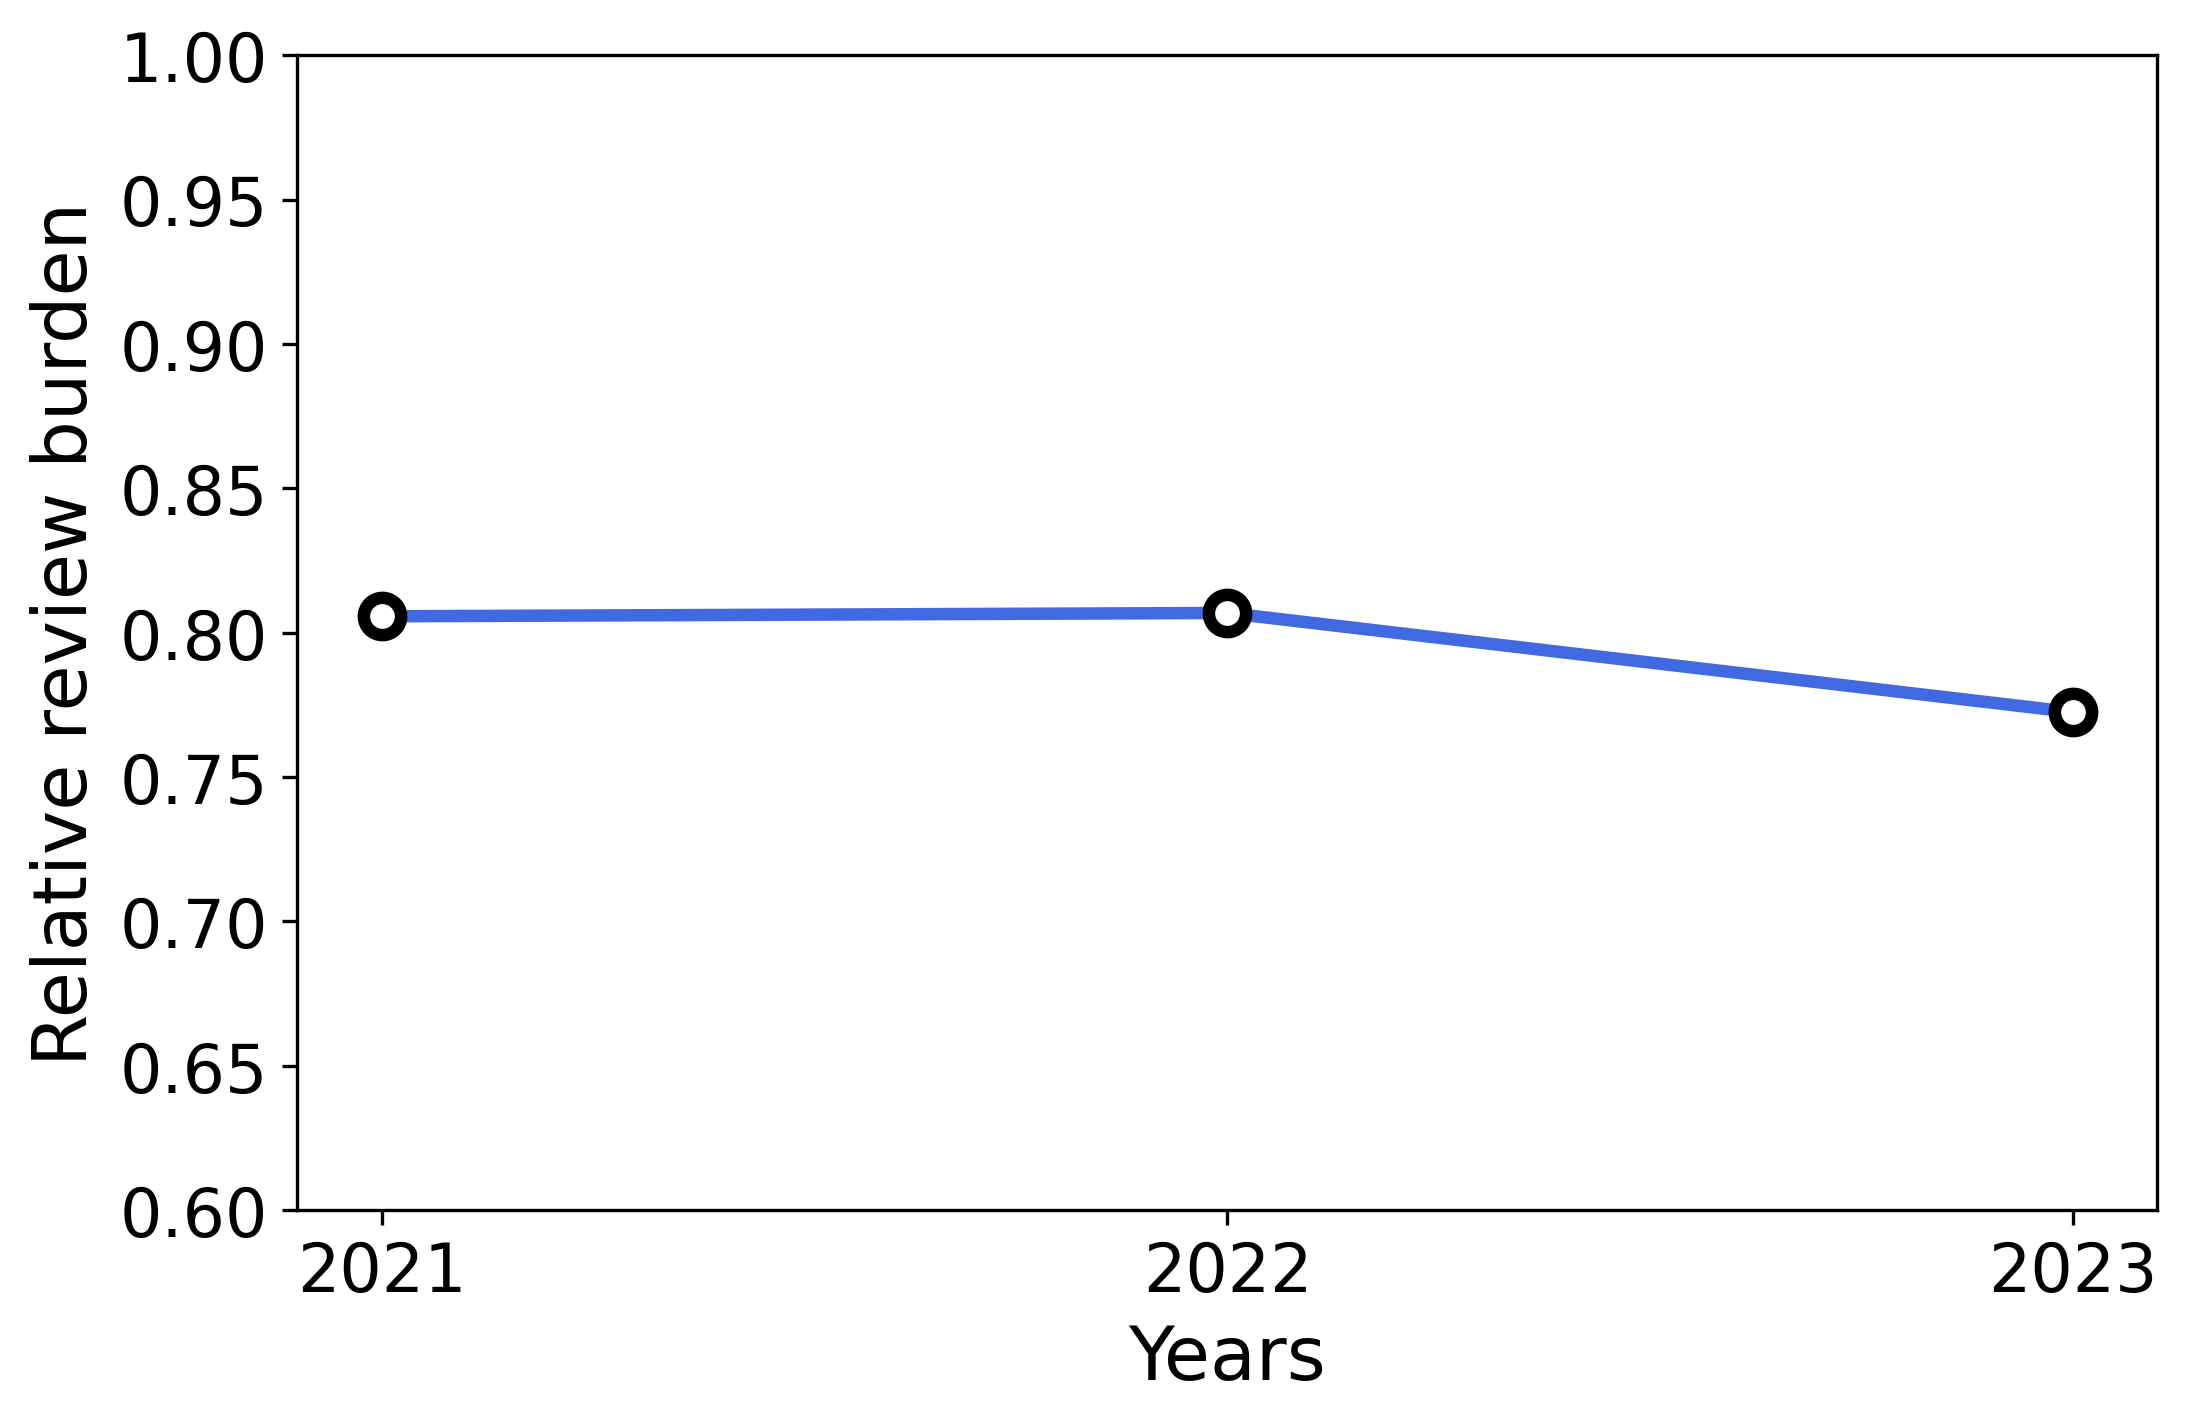

In [14]:
"""
Visualizing the relative review burden on real-data simulated model. See section 5.3.
"""

u_gain = []
r_reduce = []
for year in ['2021', '2022', '2023']:
    utility_parallel = np.load('Numerical_results/Real_data/utility_parallel_'+year+'.npy')
    utility_sequential = np.load('Numerical_results/Real_data/utility_sequential_'+year+'.npy')
    n_review_parallel = np.load('Numerical_results/Real_data/n_review_parallel_'+year+'.npy')
    n_review_sequential = np.load('Numerical_results/Real_data/n_review_sequential_'+year+'.npy')

    index = np.where(np.array(utility_sequential) >= np.max(utility_parallel))
    u_gain.append((np.max(utility_sequential) - np.max(utility_parallel))/np.max(utility_parallel))
    r_reduce.append(np.min(np.array(n_review_sequential)[index])/np.max(n_review_parallel))
    print(r_reduce)

fig, ax = plt.subplots(dpi = 300)
plt.rcParams['figure.figsize'] = (8, 5)
plt.scatter(['2021', '2022', '2023'], r_reduce, s = 80, edgecolor='black', linewidths=3, color = 'white')
plt.plot(['2021', '2022', '2023'], r_reduce, linewidth = 3, color = 'royalblue', zorder = 0)
plt.xlabel("Years", fontsize = '18')
plt.ylabel("Relative review burden", fontsize = '18')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.yaxis.grid(True, color='#B3B3B3')
# ax.xaxis.grid(False)
plt.ylim(0.6,1)

## Two phase

In [15]:
t1 = 5.5
t2 = 5.0
t_acc = 5.6
m = 3           ## num of review scores in phase 1
m1 = 5          ## num of review scores in phase 2
n = 10          ## for example an author has 21 papers
mu_q = 5.5      ## the mean of the quality prior
sig_q = 1.5     ## the std of the quality prior
N = 1000

phase1_para = RealConfParams(  ## basic parameters are the same as the original and in phase 1 we 
        n = n,
        k = m,
        mu_q = mu_q,
        sig_q = sig_q,
        t = t
        )




q_samples = sample_q(phase1_para, N)  ## sample prior quality scores for N times from Gaussian(mu_q, sig_q)
print(q_samples.shape)


(1000, 10)


In [16]:
from scipy import integrate
def compute_s_joint_prob(m): # m is the number of scores, for example 3, you'll get a dict, dict[(1,2,3)] is the probability of getting scores 1,2,3 
    scores = np.arange(1, 11) # score range, typically range(1,11)
    sum = 0                     #to check sum
    prior_s_prob = {}
    for combination in itertools.combinations_with_replacement(range(1, 11), m):    ## You can use the next line to get all combinations to check if sum≈1,
                                                                                    ##if it's too far from 1, use larger scalar in integrate.quad(func, mu_q-5*sig_q, mu_q+5*sig_q)
    # for combination in [[i,j,k] for i in range(1, 11) for j in range(1, 11) for k in range(1, 11)]:
        def func(x):
            return norm.pdf(x,mu_q, sig_q) * np.prod(np.array([np.exp(t*(k - x)**2) / (np.sum(np.exp(t*(scores[:] - x)**2) , axis = 0)) for k in combination]))
        prob = integrate.quad(func, mu_q-5*sig_q, mu_q+5*sig_q)
        prior_s_prob[tuple(combination)] = prob[0]
        sum+=prob[0]
    print(sum) #Should be <1,While this would be close to 1 if you use the second for loop but it need you to modify.
    return prior_s_prob
#prior_s_prob_m = compute_s_joint_prob(m)
#prior_s_prob_m ## P(s1,s2,s3)

# prior_s_prob_m1 = compute_s_joint_prob(m1)
# prior_s_prob_m1 ## P(s1,s2,s3,s4,s5)

In [17]:

def Expected_quality_of_combinations(m,prior_s_prob):  ## m is the number of scores, for example 3, you'll get a dict, dict[(1,2,3)] is the expected quality of getting scores 1,2,3
    scores = np.arange(1, 11)
    expected_quality = {}

    for combination in itertools.combinations_with_replacement(range(1, 11), m):
    # for combination in [[i,j,k] for i in range(1, 11) for j in range(1, 11) for k in range(1, 11)]:
        def func(x):
            return x*norm.pdf(x,mu_q, sig_q)*np.prod(np.array([np.exp(t*(k - x)**2) / (np.sum(np.exp(t*(scores[:] - x)**2) , axis = 0)) for k in combination]))/ prior_s_prob[tuple(combination)]
        expect_quality = integrate.quad(func, mu_q-5*sig_q, mu_q+5*sig_q)
        expected_quality[tuple(combination)] = expect_quality[0]
        # prob = func(5)
        # sum += prob[0]
        # print(combination, expect_quality, sum,"ppp", norm.pdf(1,mu_q, sig_q))
    return expected_quality
    
#expected_quality_m = Expected_quality_of_combinations(m, prior_s_prob_m) 
#expected_quality_m

# expected_quality_m1 = Expected_quality_of_combinations(5 , prior_s_prob_m1)
# expected_quality_m1

In [18]:
from math import factorial
def count_permutations(t):
    # Count occurrences of each unique element
    element_counts = Counter(t)
    # Calculate the factorial of the total number of items
    total_permutations = factorial(sum(element_counts.values()))
    # Divide by the factorial of each element count
    for count in element_counts.values():
        total_permutations //= factorial(count)
    return total_permutations

def phase1_acceptance_probability(para, q, prob_all,t1,t2,  expected_qualities): ## prob_all is the probability of all paper before this is accepted
    # prob_per_combination = np.empty()
    prob_per_combination = {}
    t = para.t
    k = para.k  ## here is m for phase1, m1 for phase2
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    
    scores = np.arange(1, 11)
    q_reshape = q[np.newaxis, :]
    # print(q_reshape.shape)


    for combination in itertools.combinations_with_replacement(range(1, 11), k):
        sorted_combination = tuple(sorted(combination))
        expected_quality = expected_qualities[sorted_combination]
        if expected_quality >= t1:
            prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0)
            acc_probability += np.prod(prob, axis = 0) *count_permutations(combination)
            prob_per_combination[combination] =  np.prod(prob, axis = 0) *count_permutations(combination)
            # print(acc_probability.shape)
        elif expected_quality>=t2:
            prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0)
            acc_probability += np.prod(prob, axis = 0)*prob_all *count_permutations(combination)
            prob_per_combination[combination] =  np.prod(prob, axis = 0) *count_permutations(combination)
            # print(acc_probability.shape)
        else :
            prob_per_combination[combination] = np.zeros_like(acc_probability)
            
    return acc_probability, prob_per_combination

#phase1_acceptance_probability(phase1_para, q_samples[:,0], 1, t1, t2, expected_quality_m)

In [250]:
def compute_prob_into_phase2(para, q, t1, t2, expected_quality):
    t = para.t
    k = para.k
    n = para.n
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    prob_all = np.ones((q.shape[1],q.shape[0])) ##stores the probability of all paper being accepted, initialized with ones
    all_acc_before_i = 1
    prob_per_comb = {}

    for i in range(0,math.ceil(n/2)):
        
        prob_i , prob_per_comb_i= phase1_acceptance_probability(para, q[:,i], all_acc_before_i, t1, t2, expected_quality)
        prob_per_comb[i] = prob_per_comb_i
        prob_all[i] = prob_i
        all_acc_before_i *= prob_i

    for i in range(math.ceil(n/2),n):
        prob_all[i] = all_acc_before_i


    #print([np.average(prob_all[i]) for i in range(n)])
    return prob_all , prob_per_comb

#prob_all, prob_per_comb = compute_prob_into_phase2(phase1_para, q_samples, t1, t2, expected_quality_m)

NameError: name 'prob_all' is not defined

In [24]:
print(prob_per_comb[0][(1,1,2)])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [20]:



def First_half_phase2_acceptance_probability(para, q, m,m1,prob_per_combination_phase1,t_acc): ## prob_all is the probability of all paper before this is accepted
    t = para.t
    k = para.k  ## here is m for phase1, m1 for phase2
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    
    scores = np.arange(1, 11)
    q_reshape = q[np.newaxis, :]
    # print(q_reshape.shape)


    for combination in itertools.combinations_with_replacement(range(1, 11), m1-m):
        for p1_combination in itertools.combinations_with_replacement(range(1, 11), m):
            if np.sum(combination)+np.sum(p1_combination) >= t_acc * m1:
                prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0) 
                acc_probability += np.prod(prob, axis = 0)*count_permutations(combination)* prob_per_combination_phase1[p1_combination]
                # print(acc_probability.shape)
        
            
    return acc_probability


def Last_half_phase2_acceptance_probability(para, q, t_acc): ## prob_all is the probability of all paper before this is accepted
    t = para.t
    k = para.k  ## here is m for phase1, m1 for phase2
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    
    scores = np.arange(1, 11)
    q_reshape = q[np.newaxis, :]
    # print(q_reshape.shape)

    # for i in range(len(q)):
    #     acc_probability[i] = acceptance_probability(q[i], k, t_acc, t)
        
    for combination in itertools.combinations_with_replacement(range(1, 11), k):
        
        if np.sum(combination) >= t_acc * m1:
            prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0)
            acc_probability += np.prod(prob, axis = 0)*count_permutations(combination)
            # print(acc_probability.shape)
        
            
    return acc_probability




In [21]:
count_num = 0

#IsComputed = {}
#acceptance_probability_q_m = {}
#acceptance_probability_q_m_m1 = {}

def acceptance_probability(q, m, t_acc, t):
    global count_num
    if(not((q,m) in IsComputed)):
        #print(count_num)
        count_num += 1
        temp = {}
        num = 0.0
        for score in range(1,11):
            num += np.exp(t * (score - q) ** 2)
        for combination in itertools.combinations_with_replacement(range(1,11), m):
            total = np.sum(combination)
            if(not(total in temp)):
                temp[total] = 0
            prob = -1
            for s in combination:
                if(prob == -1):
                    prob = np.exp(t * (s - q) ** 2) / num
                else:
                    prob *= np.exp(t * (s - q) ** 2) / num
            temp[total] += prob * count_permutations(combination)
        sum_array = [0.0]
        for i in temp.items():
            sum_array.append(i[1] + sum_array[-1])
        acceptance_probability_q_m[(q,m)] = sum_array 
        IsComputed[(q,m)] = 1
    scores_sum = np.array(range(m, m * 10 + 1))
    scores_sum = np.insert(scores_sum, 0, 0)
    target = t_acc * m
    #if(target > m * 10):
    #    return 0
    index = bisect.bisect_left(scores_sum, target)
    return acceptance_probability_q_m[(q,m)][-1] - acceptance_probability_q_m[(q,m)][index-1]

def acceptance_probability_ex(q, m, m1, t_acc, t, p1, pos):
    global count_num
    if(not((q,m,m1) in IsComputed)):
        #print(count_num)
        count_num += 1
        temp = {}
        num = 0.0
        for score in range(1,11):
            num += np.exp(t * (score - q) ** 2)
        for combination in itertools.combinations_with_replacement(range(1,11), m1-m):
            for p1_combination in itertools.combinations_with_replacement(range(1, 11), m):
                total = np.sum(combination) + np.sum(p1_combination)
                if(not(total in temp)):
                    temp[total] = 0
                prob = -1
                for s in combination:
                    if(prob == -1):
                        prob = np.exp(t * (s - q) ** 2) / num
                    else:
                        prob *= np.exp(t * (s - q) ** 2) / num
                temp[total] += prob * count_permutations(combination) * p1[p1_combination][pos]
        sum_array = [0.0]
        for i in temp.items():
            sum_array.append(i[1] + sum_array[-1])
        acceptance_probability_q_m_m1[(q,m,m1)] = sum_array 
        IsComputed[(q,m,m1)] = 1
    scores_sum = np.array(range(m1, m1 * 10 + 1))
    scores_sum = np.insert(scores_sum, 0, 0)
    target = t_acc * m1
    #if(target > m * 10):
    #    return 0
    index = bisect.bisect_left(scores_sum, target)
    return acceptance_probability_q_m_m1[(q,m,m1)][-1] - acceptance_probability_q_m_m1[(q,m,m1)][index-1]
    #print(acceptance_probability_q_m_m1[(q,m,m1)][-1] - acceptance_probability_q_m_m1[(q,m,m1)][index-1])
    #return 0


def test_Last_half_phase2_acceptance_probability(para, q, t_acc): ## prob_all is the probability of all paper before this is accepted
    t = para.t
    k = para.k  ## here is m for phase1, m1 for phase2
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    for i in range(len(q)):
        acc_probability[i] = acceptance_probability(q[i], k, t_acc, t)
    return acc_probability

def test_First_half_phase2_acceptance_probability(para, q, m,m1,prob_per_combination_phase1,t_acc): ## prob_all is the probability of all paper before this is accepted
    t = para.t
    k = para.k  ## here is m for phase1, m1 for phase2
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    for i in range(len(q)):
        #for j in prob_per_combination_phase1.items():
        #    temp.append((j[0]))
        acc_probability[i] = acceptance_probability_ex(q[i], m, m1, t_acc, t, prob_per_combination_phase1, i)            
    return acc_probability

In [27]:
s = (1,2,3,4,5)
q=np.array([9,9,9,9,9,9,9,9,9,10])
s_sum = np.sum([i*i + q*q-2*i*q for i in s],axis = 0)
s_sum

array([190, 190, 190, 190, 190, 190, 190, 190, 190, 255])

In [28]:
print([np.average(q_samples[:,i]) for i in range(10)])

[7.870163925161963, 7.043752833989955, 6.517128184281027, 6.082894979157359, 5.678467250917978, 5.2976175629817925, 4.915944984042003, 4.502285026108402, 3.9615424262399093, 3.1692116963417094]


In [33]:
import bisect

In [52]:
phase2_para = phase1_para
phase2_para.k = m1
final_prob_all = np.copy(prob_all)
print([np.average(final_prob_all[i]) for i in range(n)])
for i in range(0, n ):
    if(i< math.ceil(n/2)):
        prob_i = First_half_phase2_acceptance_probability(phase2_para, q_samples[:,i], m, m1, prob_per_comb[i], t_acc)
    else:
        prob_i = Last_half_phase2_acceptance_probability(phase2_para, q_samples[:,i], t_acc)


    print(i,": ",np.average(prob_i))
    final_prob_all[i] *= prob_i

print([np.average(final_prob_all[i]) for i in range(n)])

[0.9989758599373428, 0.9933663648009553, 0.9751302886165637, 0.9256974790266982, 0.8150238105937546, 0.8150238105937546, 0.8150238105937546, 0.8150238105937546, 0.8150238105937546, 0.8150238105937546]
0 :  0.9950461542137796
1 :  0.9715530153446557
2 :  0.907603984379741
3 :  0.7776604435114086
4 :  0.5887674570830081
5 :  0.3896473796142081
6 :  0.22050638130230862
7 :  0.09945952816478522
8 :  0.030313707478229455
9 :  0.004849762100354826
[0.9944742203709234, 0.9682222345108653, 0.896622505559976, 0.7524865264524114, 0.5486989260334725, 0.3686489573398818, 0.21067627970559694, 0.09593501808320534, 0.029431898661287172, 0.004756652077478867]


In [83]:
prob_per_comb[0].__class__

dict

In [85]:
phase2_para = phase1_para
phase2_para.k = m1
final_prob_all = np.copy(prob_all)
print([np.average(final_prob_all[i]) for i in range(n)])
for i in range(0, n ):
    if(i< math.ceil(n/2)):
        prob_i = test_First_half_phase2_acceptance_probability(phase2_para, q_samples[:,i], m, m1, prob_per_comb[i], t_acc)
    else:
        prob_i = test_Last_half_phase2_acceptance_probability(phase2_para, q_samples[:,i], t_acc)


    print(i,": ",np.average(prob_i))
    final_prob_all[i] *= prob_i

print([np.average(final_prob_all[i]) for i in range(n)])

[0.9989758599373428, 0.9933663648009553, 0.9751302886165637, 0.9256974790266982, 0.8150238105937546, 0.8150238105937546, 0.8150238105937546, 0.8150238105937546, 0.8150238105937546, 0.8150238105937546]
0 :  0.9950461542137796
1 :  0.9715530153446557
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2

In [30]:
aver_quality = np.zeros(1000)
rev_n = np.zeros(1000)
for i in range(n):
    aver_quality += (q_samples[:,i]-5.5)*final_prob_all[i]
    #rev_n += m1*final_prob_all[i]+m*(1-(final_prob_all[i]/prob_all[i]))* (1 if i < math.ceil(n/2) else 0)
    rev_n += m1*prob_all[i] + m*(1-prob_all[i])*(1 if i < math.ceil(n/2) else 0)
print(np.average(aver_quality), np.average(rev_n)/n)

5.911075753672349 4.47919828707945


In [26]:
import bisect

In [144]:
n = 10
def two_phase_experiment(num, num1):
    global m, m1, t1, t2, t_acc, IsComputed, acceptance_probability_q_m, acceptance_probability_q_m_m1
    quality = []
    burden = []
    res = []
    m = num
    m1 = num1
    prior_s_prob_m = compute_s_joint_prob(m)
    prior_s_prob_m1 = compute_s_joint_prob(m1)
    expected_quality_m = Expected_quality_of_combinations(m , prior_s_prob_m)
    t1_range = np.arange(2.0, 8.1, 0.4)
    t2_range = np.arange(2.0, 8.1, 0.4)
    tacc_range = np.arange(5.0, 6.6, 0.5)
    IsComputed = {}
    acceptance_probability_q_m = {}
    acceptance_probability_q_m_m1 = {}
    for ii in range(len(t1_range)):
        for j in range(len(t2_range)):
            for k in range(len(tacc_range)):
                t1 = t1_range[ii]
                t2 = t2_range[j]
                t_acc = tacc_range[k]
                print(t1, t2, t_acc)
                phase1_para = RealConfParams(  ## basic parameters are the same as the original and in phase 1 we 
                    n = n,
                    k = m,
                    mu_q = mu_q,
                    sig_q = sig_q,
                    t = t
                )
                phase1_acceptance_probability(phase1_para, q_samples[:,0], 1, t1, t2, expected_quality_m)
                prob_all, prob_per_comb = compute_prob_into_phase2(phase1_para, q_samples, t1, t2, expected_quality_m)
                phase2_para = phase1_para
                phase2_para.k = m1
                final_prob_all = np.copy(prob_all)
                #print([np.average(final_prob_all[i]) for i in range(n)])
                for i in range(0, n):
                    if(i< math.ceil(n/2)):
                        prob_i = test_First_half_phase2_acceptance_probability(phase2_para, q_samples[:,i], m, m1, prob_per_comb[i], t_acc)
                    else:
                        prob_i = test_Last_half_phase2_acceptance_probability(phase2_para, q_samples[:,i], t_acc)
                    #print(i,": ",np.average(prob_i))
                    final_prob_all[i] *= prob_i
                #print([np.average(final_prob_all[i]) for i in range(n)])
                aver_quality = np.zeros(1000)
                rev_n = np.zeros(1000)
                expected_number = 0.0
                for i in range(n):
                    aver_quality += (q_samples[:,i]-5.5)*final_prob_all[i]
                    expected_number += np.sum(final_prob_all[i])
                    #rev_n += m1*final_prob_all[i]+m*(1-(final_prob_all[i]/prob_all[i]))* (1 if i < math.ceil(n/2) else 0)
                    rev_n += m1*prob_all[i] + m*(1-prob_all[i])*(1 if i < math.ceil(n/2) else 0)
                #print(np.average(aver_quality), np.average(rev_n)/n)
                quality.append(np.average(aver_quality))
                burden.append(np.average(rev_n)/n)
                res.append((t1,t2,t_acc,expected_number))
    x = []
    y = []
    color = []
    shapes = []
    pareto_x = []
    pareto_y = []
    pareto_res = []
    normal_x = []
    normal_y = []
    pareto_color = []
    normal_color = []
    for i in burden:
        x.append(float(i))
    for i in quality:
        y.append(float(i))
    cnt = 0
    for i in burden:
        flag = 1
        for j in range(len(x)):
            if((x[j]<x[cnt] and y[j]>y[cnt]) or (x[j] == x[cnt] and y[j]>y[cnt]) or (x[j]<x[cnt] and y[j] == y[cnt])):
                flag = 0
        if(flag == 1):
            pareto_x.append(x[cnt])
            pareto_y.append(y[cnt])
            #pareto_color.append(color[cnt])
            pareto_res.append(res[cnt])
        else:
            normal_x.append(x[cnt])
            normal_y.append(y[cnt])
            #normal_color.append(color[cnt])
        cnt += 1
    np.save("m"+str(m)+str(m1)+"b", pareto_x)
    np.save("m"+str(m)+str(m1)+"q", pareto_y)
    np.save("m"+str(m)+str(m1)+"r", pareto_res)
    np.save("m"+str(m)+str(m1)+"x", x)
    np.save("m"+str(m)+str(m1)+"y", y)
    np.save("m"+str(m)+str(m1)+"a", res)
    plt.figure(dpi=200)
    plt.ylim(0,6)
    plt.yticks(np.arange(0,6.1,0.5))
    plt.xticks(np.arange(0,6.1,0.25))
    plt.axhline(y=5.5, color='black', linestyle='--', linewidth = 3,zorder=0)
    #plt.figure(dpi=120)
    plt.scatter(normal_x, normal_y, 3, 'b')
    plt.scatter(pareto_x, pareto_y, 3, 'r')
    plt.xlabel(r"Review Burden $R$",fontsize=18)
    plt.ylabel(r"Conference Quality $Q$", fontsize=18)
    plt.title("tradeoff when m="+str(m) + "and m'="+str(m1),fontsize=20)
    plt.show()

In [45]:
IsComputed = {}
acceptance_probability_q_m = {}
acceptance_probability_q_m_m1 = {}
two_phase_experiment(1, 3)

0.9999994266968336
0.3430238783951724
3.0 3.0 3.0
3.0 3.0 3.4
3.0 3.0 3.8
3.0 3.0 4.199999999999999
3.0 3.0 4.6
3.0 3.0 5.0
3.0 3.0 5.3999999999999995
3.0 3.0 5.799999999999999
3.0 3.0 6.199999999999999
3.0 3.0 6.6
3.0 3.0 6.999999999999999
3.0 3.0 7.399999999999999
3.0 3.0 7.799999999999999
3.0 3.4 3.0
3.0 3.4 3.4
3.0 3.4 3.8
3.0 3.4 4.199999999999999
3.0 3.4 4.6
3.0 3.4 5.0
3.0 3.4 5.3999999999999995
3.0 3.4 5.799999999999999
3.0 3.4 6.199999999999999
3.0 3.4 6.6
3.0 3.4 6.999999999999999
3.0 3.4 7.399999999999999
3.0 3.4 7.799999999999999
3.0 3.8 3.0
3.0 3.8 3.4
3.0 3.8 3.8
3.0 3.8 4.199999999999999
3.0 3.8 4.6
3.0 3.8 5.0
3.0 3.8 5.3999999999999995
3.0 3.8 5.799999999999999
3.0 3.8 6.199999999999999
3.0 3.8 6.6
3.0 3.8 6.999999999999999
3.0 3.8 7.399999999999999
3.0 3.8 7.799999999999999
3.0 4.199999999999999 3.0
3.0 4.199999999999999 3.4
3.0 4.199999999999999 3.8
3.0 4.199999999999999 4.199999999999999
3.0 4.199999999999999 4.6
3.0 4.199999999999999 5.0
3.0 4.199999999999999 5.399

In [46]:
x = []
y = []
color = []
shapes = []
pareto_x = []
pareto_y = []
normal_x = []
normal_y = []
pareto_color = []
normal_color = []
for i in burden:
    x.append(float(i))
for i in quality:
    y.append(float(i))
cnt = 0
for i in burden:
    flag = 1
    for j in range(len(x)):
        if((x[j]<x[cnt] and y[j]>y[cnt]) or (x[j] == x[cnt] and y[j]>y[cnt]) or (x[j]<x[cnt] and y[j] == y[cnt])):
            flag = 0
    if(flag == 1):
        pareto_x.append(x[cnt])
        pareto_y.append(y[cnt])
        #pareto_color.append(color[cnt])
    else:
        normal_x.append(x[cnt])
        normal_y.append(y[cnt])
        #normal_color.append(color[cnt])
    cnt += 1

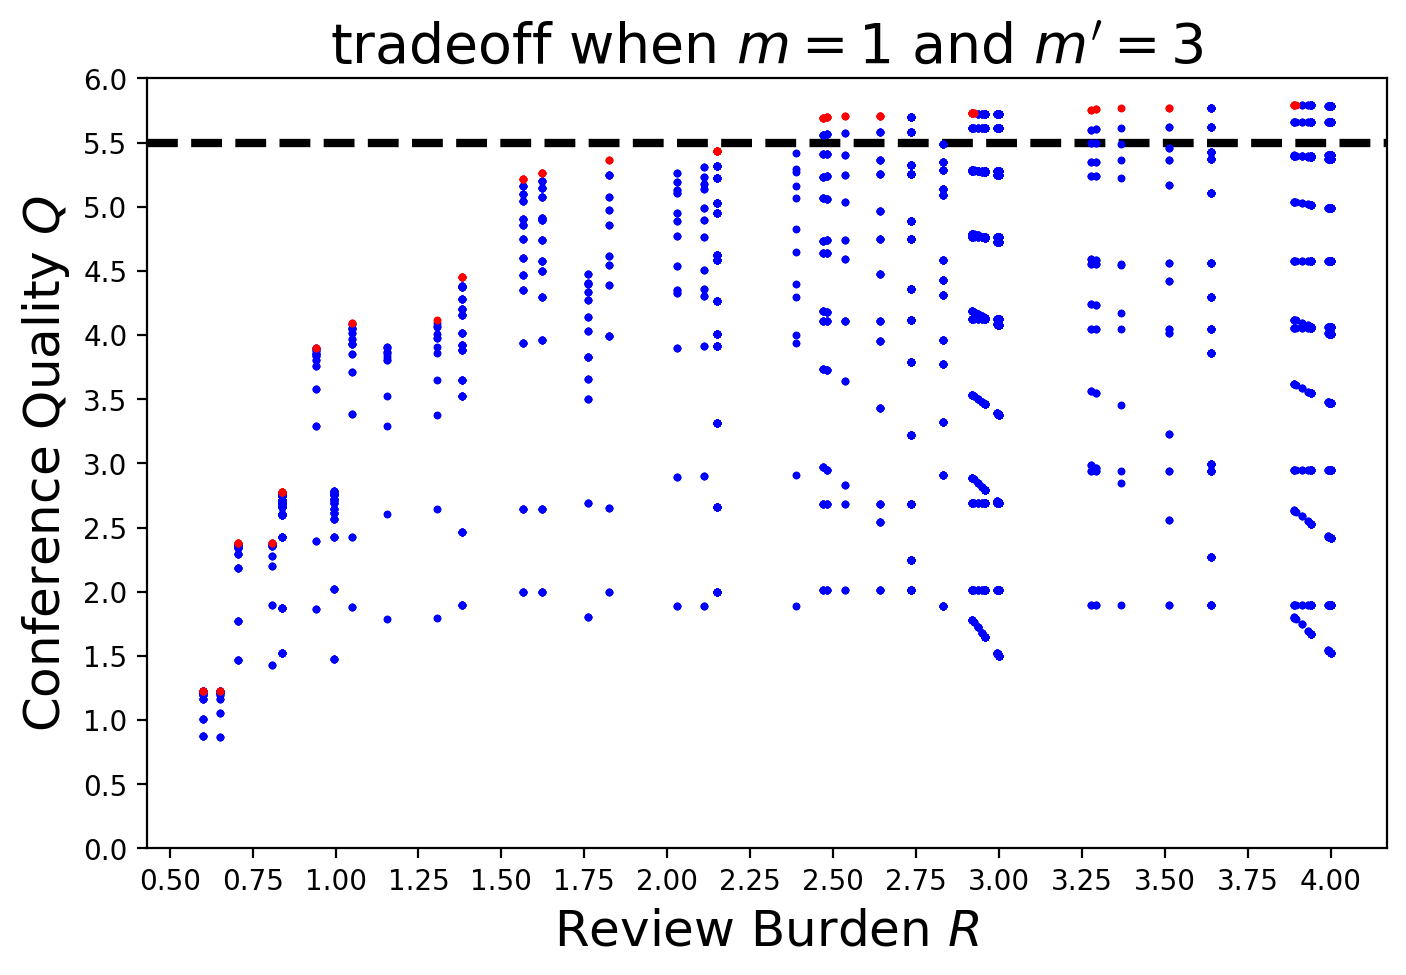

In [47]:
plt.figure(dpi=200)
plt.ylim(0,6)
plt.yticks(np.arange(0,6.1,0.5))
plt.xticks(np.arange(0,6.1,0.25))
plt.axhline(y=5.5, color='black', linestyle='--', linewidth = 3,zorder=0)
#plt.figure(dpi=120)
plt.scatter(normal_x, normal_y, 3, 'b')
plt.scatter(pareto_x, pareto_y, 3, 'r')
plt.xlabel(r"Review Burden $R$",fontsize=18)
plt.ylabel(r"Conference Quality $Q$", fontsize=18)
plt.title(r"tradeoff when $m=1$ and $m^\prime=3$",fontsize=20)
plt.show()

In [48]:
pareto_x_13 = pareto_x
pareto_y_13 = pareto_y

In [49]:
np.save("m13b",pareto_x_13)
np.save("m13q",pareto_y_13)

In [40]:
IsComputed = {}
acceptance_probability_q_m = {}
acceptance_probability_q_m_m1 = {}
two_phase_experiment(1, 4)

0.9999994266968336
0.164887878506987
3.0 3.0 3.0
3.0 3.0 3.4
3.0 3.0 3.8
3.0 3.0 4.199999999999999
3.0 3.0 4.6
3.0 3.0 5.0
3.0 3.0 5.3999999999999995
3.0 3.0 5.799999999999999
3.0 3.0 6.199999999999999
3.0 3.0 6.6
3.0 3.0 6.999999999999999
3.0 3.0 7.399999999999999
3.0 3.0 7.799999999999999
3.0 3.4 3.0
3.0 3.4 3.4
3.0 3.4 3.8
3.0 3.4 4.199999999999999
3.0 3.4 4.6
3.0 3.4 5.0
3.0 3.4 5.3999999999999995
3.0 3.4 5.799999999999999
3.0 3.4 6.199999999999999
3.0 3.4 6.6
3.0 3.4 6.999999999999999
3.0 3.4 7.399999999999999
3.0 3.4 7.799999999999999
3.0 3.8 3.0
3.0 3.8 3.4
3.0 3.8 3.8
3.0 3.8 4.199999999999999
3.0 3.8 4.6
3.0 3.8 5.0
3.0 3.8 5.3999999999999995
3.0 3.8 5.799999999999999
3.0 3.8 6.199999999999999
3.0 3.8 6.6
3.0 3.8 6.999999999999999
3.0 3.8 7.399999999999999
3.0 3.8 7.799999999999999
3.0 4.199999999999999 3.0
3.0 4.199999999999999 3.4
3.0 4.199999999999999 3.8
3.0 4.199999999999999 4.199999999999999
3.0 4.199999999999999 4.6
3.0 4.199999999999999 5.0
3.0 4.199999999999999 5.3999

In [41]:
x = []
y = []
color = []
shapes = []
pareto_x = []
pareto_y = []
normal_x = []
normal_y = []
pareto_color = []
normal_color = []
for i in burden:
    x.append(float(i))
for i in quality:
    y.append(float(i))
cnt = 0
for i in burden:
    flag = 1
    for j in range(len(x)):
        if((x[j]<x[cnt] and y[j]>y[cnt]) or (x[j] == x[cnt] and y[j]>y[cnt]) or (x[j]<x[cnt] and y[j] == y[cnt])):
            flag = 0
    if(flag == 1):
        pareto_x.append(x[cnt])
        pareto_y.append(y[cnt])
        #pareto_color.append(color[cnt])
    else:
        normal_x.append(x[cnt])
        normal_y.append(y[cnt])
        #normal_color.append(color[cnt])
    cnt += 1

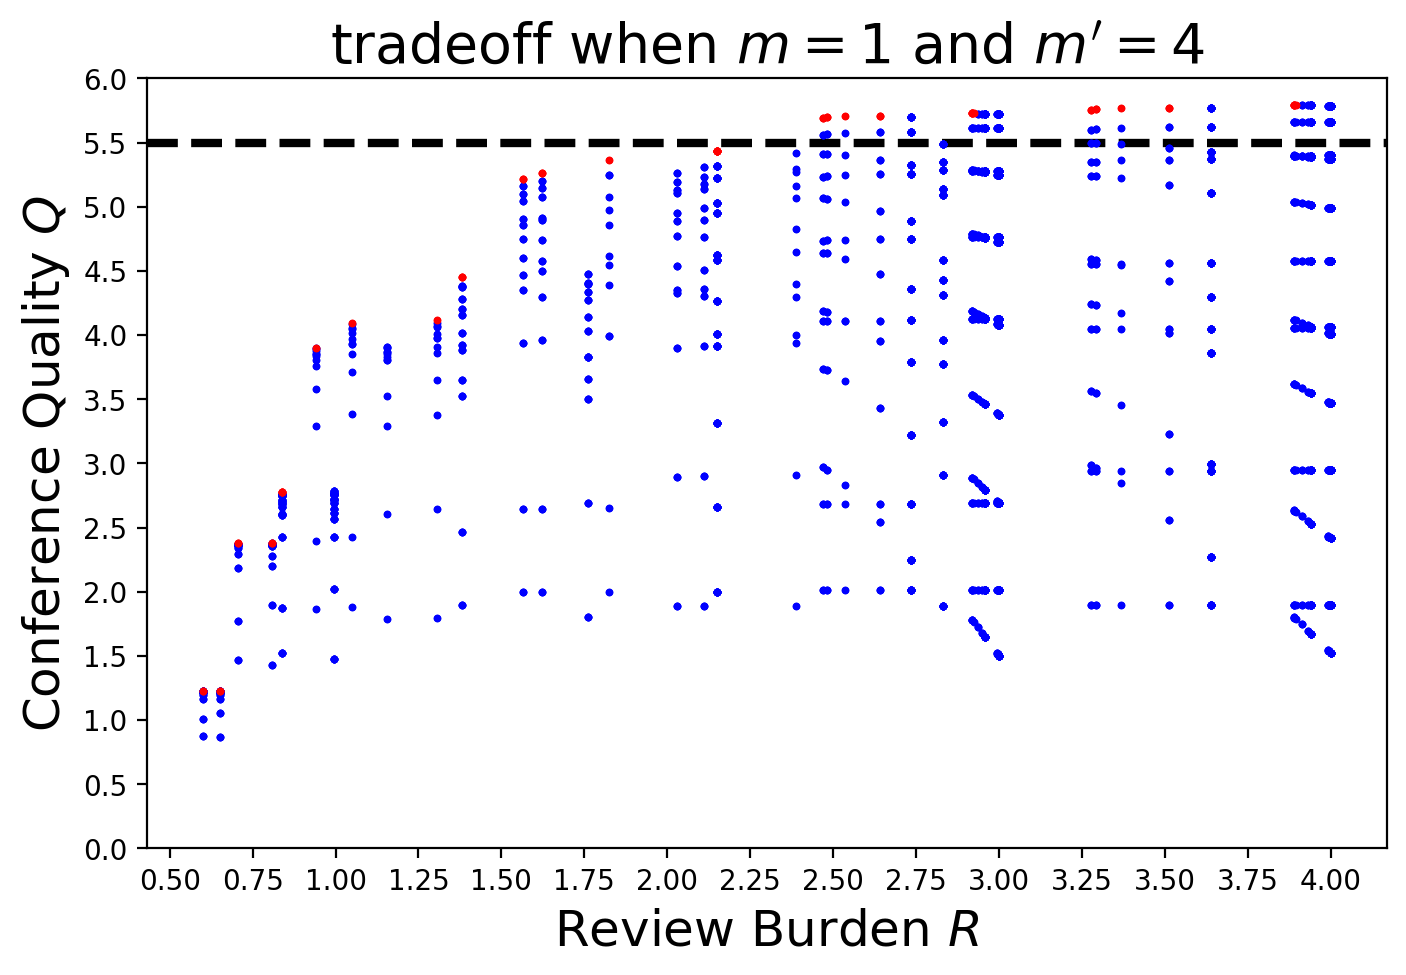

In [44]:
plt.figure(dpi=200)
plt.ylim(0,6)
plt.yticks(np.arange(0,6.1,0.5))
plt.xticks(np.arange(0,6.1,0.25))
plt.axhline(y=5.5, color='black', linestyle='--', linewidth = 3,zorder=0)
#plt.figure(dpi=120)
plt.scatter(normal_x, normal_y, 3, 'b')
plt.scatter(pareto_x, pareto_y, 3, 'r')
plt.xlabel(r"Review Burden $R$",fontsize=18)
plt.ylabel(r"Conference Quality $Q$", fontsize=18)
plt.title(r"tradeoff when $m=1$ and $m^\prime=4$",fontsize=20)
plt.show()

In [43]:
pareto_x_14 = pareto_x
pareto_y_14 = pareto_y
np.save("m14b",pareto_x_14)
np.save("m14q",pareto_y_14)

In [53]:
print("m"+str(m)+str(m1)+"b")

m13b


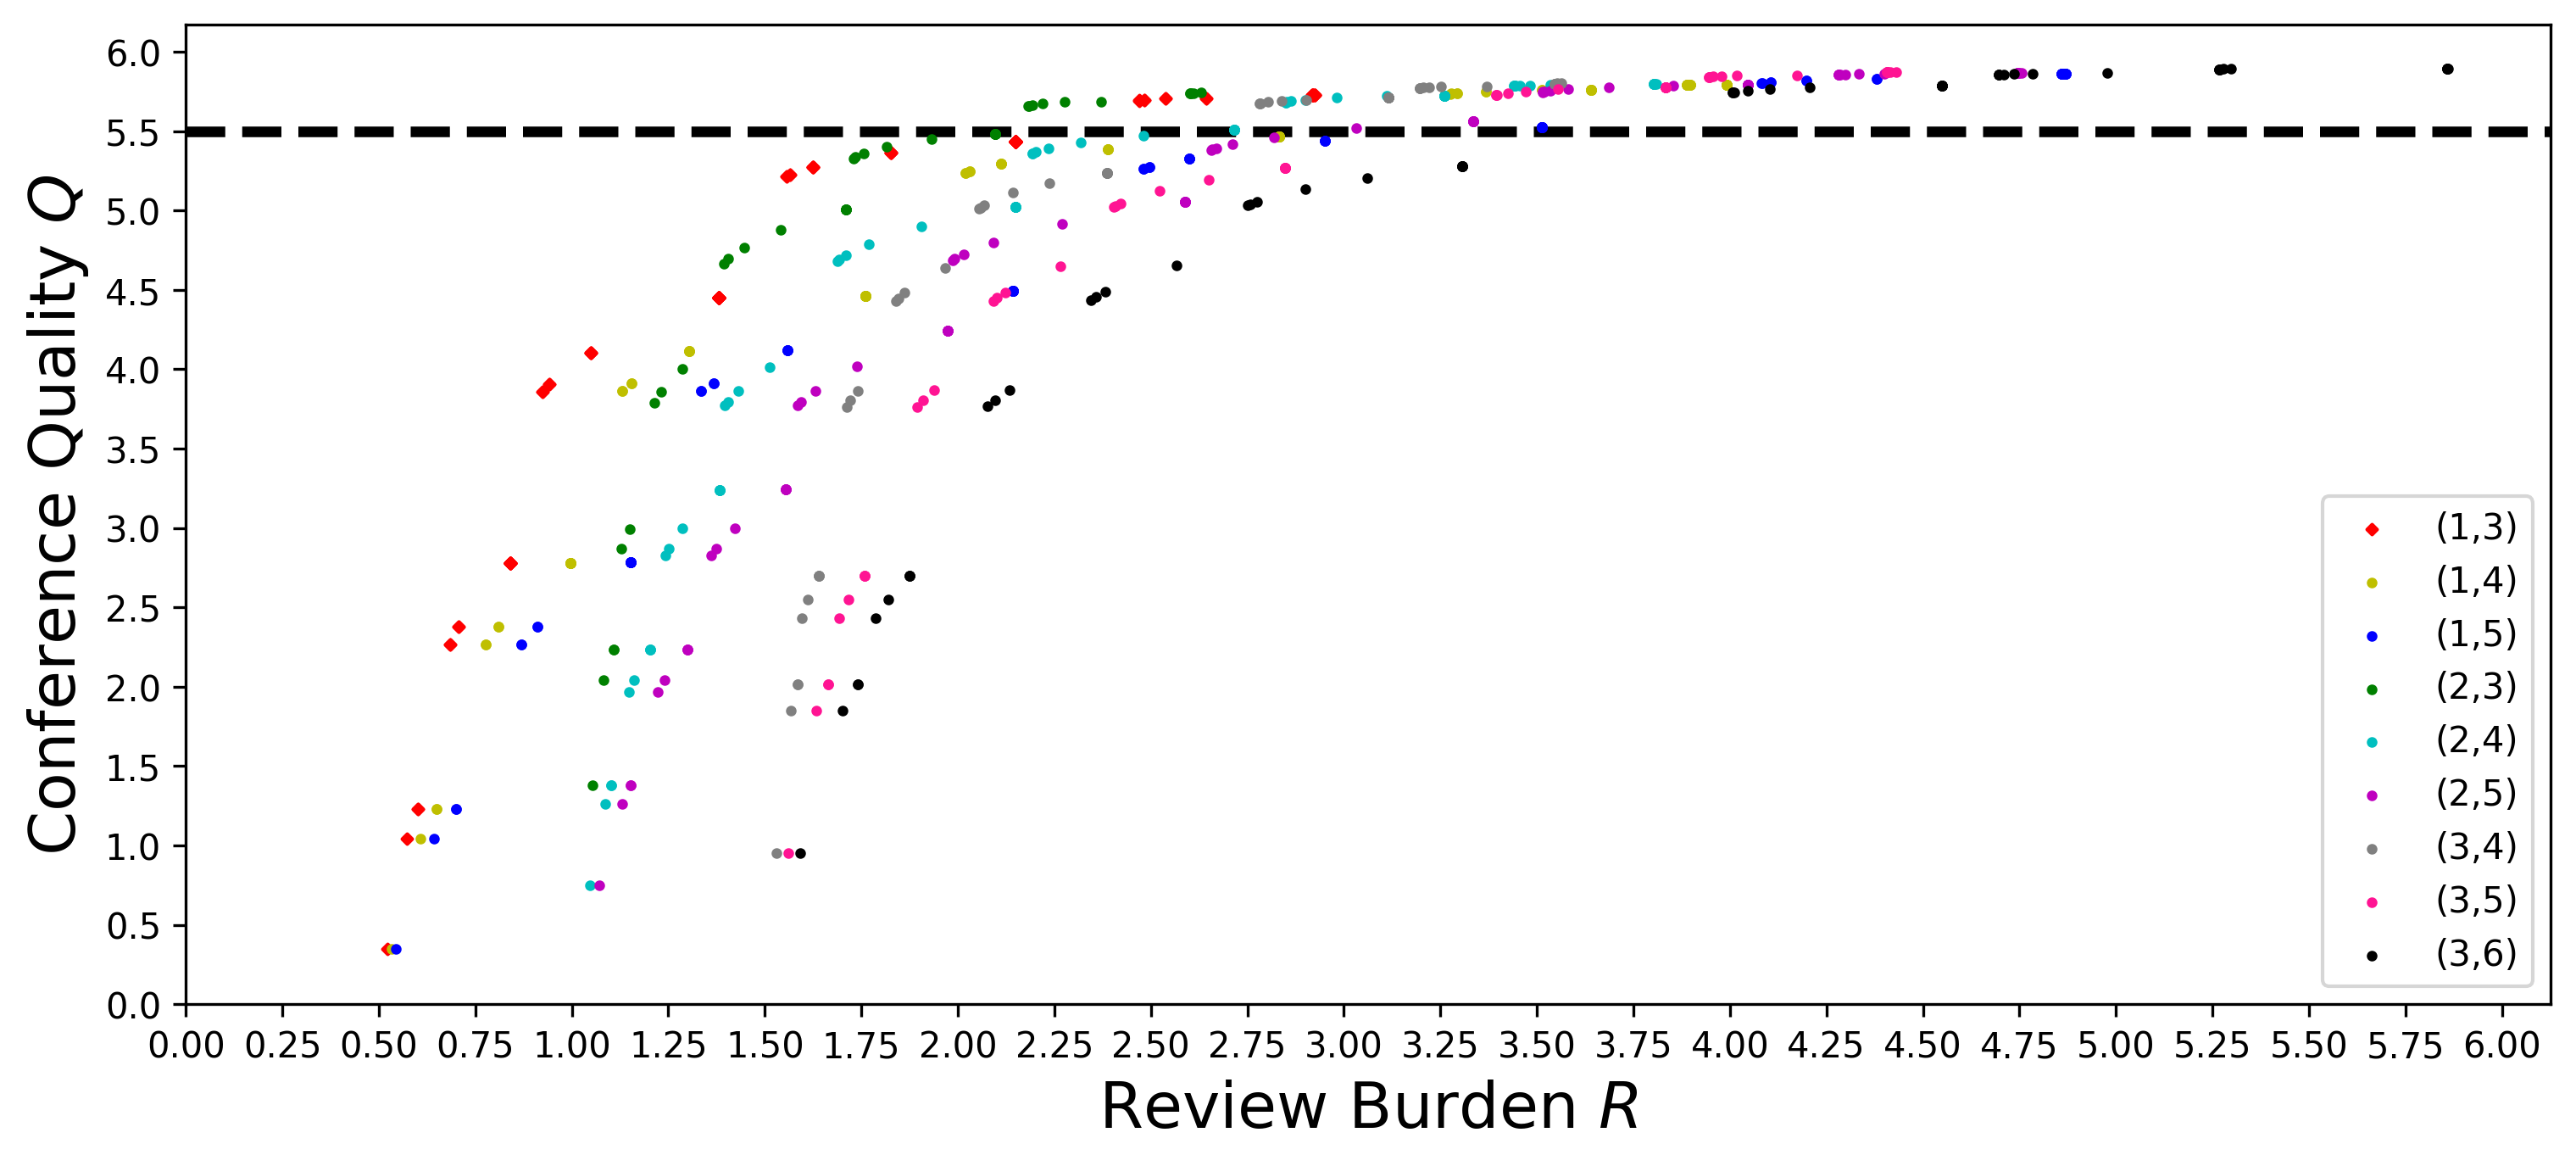

In [120]:
# draw_pareto_optimal
plt.figure(dpi=300, figsize=(12,5))

siz = 4

x = np.load('m13b.npy')
y = np.load('m13q.npy')
plt.scatter(x,y,siz,'r','D',label='(1,3)')

x = np.load('m14b.npy')
y = np.load('m14q.npy')
plt.scatter(x,y,siz,'y',label='(1,4)')

x = np.load('m15b.npy')
y = np.load('m15q.npy')
plt.scatter(x,y,siz,'b',label='(1,5)')

x = np.load('m23b.npy')
y = np.load('m23q.npy')
plt.scatter(x,y,siz,'g',label='(2,3)')

x = np.load('m24b.npy')
y = np.load('m24q.npy')
plt.scatter(x,y,siz,'c',label='(2,4)')

x = np.load('m25b.npy')
y = np.load('m25q.npy')
plt.scatter(x,y,siz,'m',label='(2,5)')

x = np.load('m34b.npy')
y = np.load('m34q.npy')
plt.scatter(x,y,siz,'grey',label='(3,4)')

x = np.load('m35b.npy')
y = np.load('m35q.npy')
plt.scatter(x,y,siz,'deeppink',label='(3,5)')

x = np.load('m36b.npy')
y = np.load('m36q.npy')
plt.scatter(x,y,siz,'k',label='(3,6)')

plt.xlabel(r"Review Burden $R$",fontsize=18)
plt.ylabel(r"Conference Quality $Q$", fontsize=18)
plt.axhline(y=5.5, color='black', linestyle='--', linewidth = 3,zorder=0)
plt.yticks(np.arange(0,6.1,0.5))
plt.xticks(np.arange(0,6.1,0.25))

plt.legend()
plt.show()

0.9999994266968336
0.3430238783951724
2.0 2.0 5.0
2.0 2.0 5.5
2.0 2.0 6.0
2.0 2.0 6.5
2.0 2.4 5.0
2.0 2.4 5.5
2.0 2.4 6.0
2.0 2.4 6.5
2.0 2.8 5.0
2.0 2.8 5.5
2.0 2.8 6.0
2.0 2.8 6.5
2.0 3.1999999999999997 5.0
2.0 3.1999999999999997 5.5
2.0 3.1999999999999997 6.0
2.0 3.1999999999999997 6.5
2.0 3.5999999999999996 5.0
2.0 3.5999999999999996 5.5
2.0 3.5999999999999996 6.0
2.0 3.5999999999999996 6.5
2.0 3.9999999999999996 5.0
2.0 3.9999999999999996 5.5
2.0 3.9999999999999996 6.0
2.0 3.9999999999999996 6.5
2.0 4.3999999999999995 5.0
2.0 4.3999999999999995 5.5
2.0 4.3999999999999995 6.0
2.0 4.3999999999999995 6.5
2.0 4.799999999999999 5.0
2.0 4.799999999999999 5.5
2.0 4.799999999999999 6.0
2.0 4.799999999999999 6.5
2.0 5.199999999999999 5.0
2.0 5.199999999999999 5.5
2.0 5.199999999999999 6.0
2.0 5.199999999999999 6.5
2.0 5.6 5.0
2.0 5.6 5.5
2.0 5.6 6.0
2.0 5.6 6.5
2.0 5.999999999999999 5.0
2.0 5.999999999999999 5.5
2.0 5.999999999999999 6.0
2.0 5.999999999999999 6.5
2.0 6.399999999999999 5.0


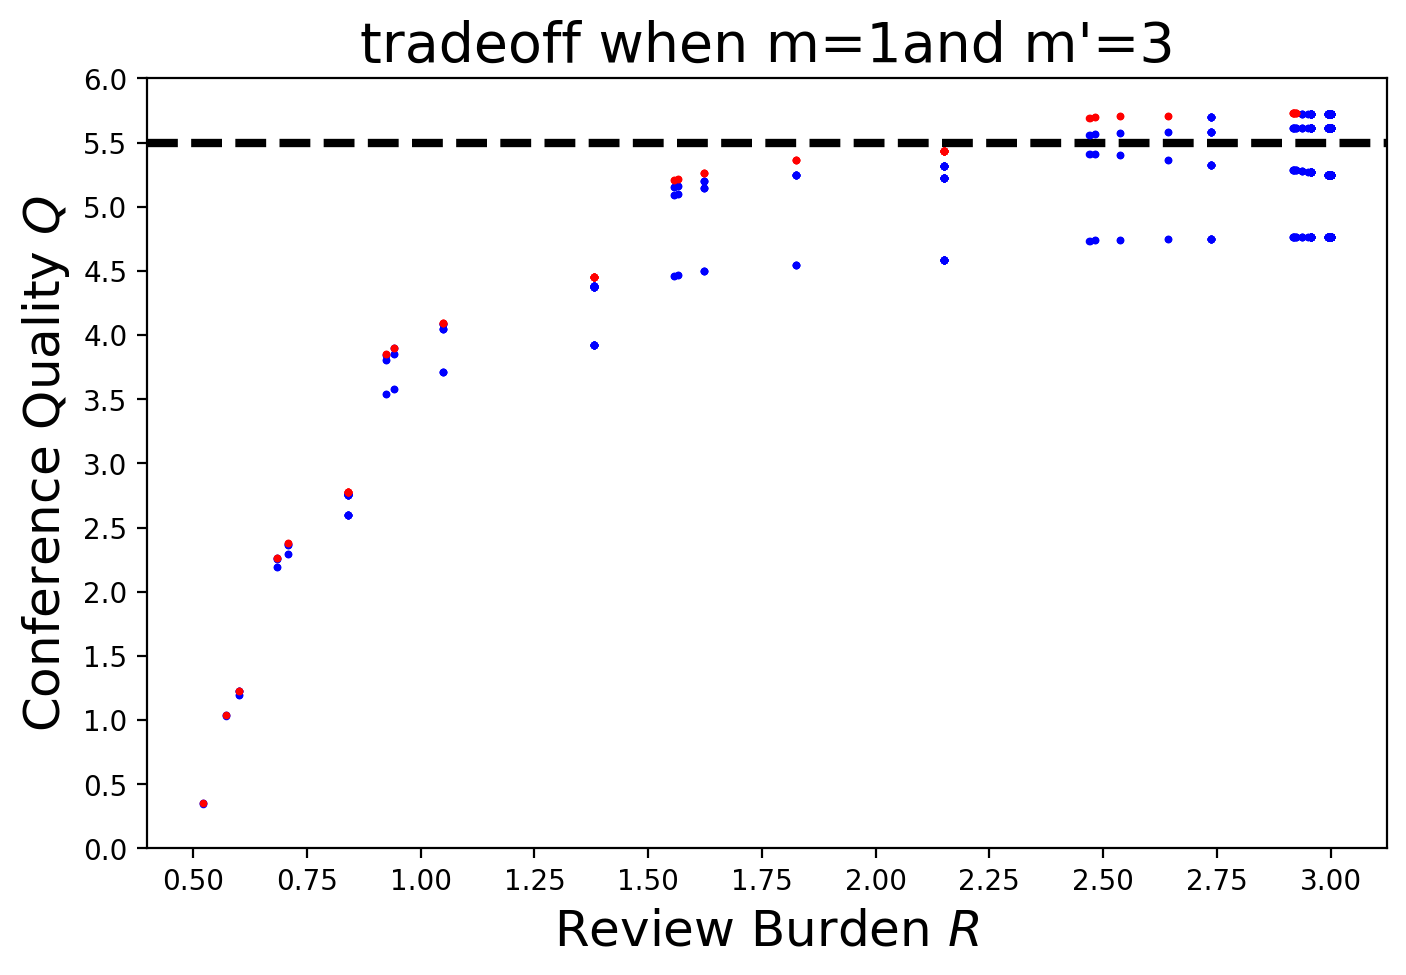

In [145]:
two_phase_experiment(1, 3)

0.9999994266968336
0.164887878506987
2.0 2.0 5.0
2.0 2.0 5.5
2.0 2.0 6.0
2.0 2.0 6.5
2.0 2.4 5.0
2.0 2.4 5.5
2.0 2.4 6.0
2.0 2.4 6.5
2.0 2.8 5.0
2.0 2.8 5.5
2.0 2.8 6.0
2.0 2.8 6.5
2.0 3.1999999999999997 5.0
2.0 3.1999999999999997 5.5
2.0 3.1999999999999997 6.0
2.0 3.1999999999999997 6.5
2.0 3.5999999999999996 5.0
2.0 3.5999999999999996 5.5
2.0 3.5999999999999996 6.0
2.0 3.5999999999999996 6.5
2.0 3.9999999999999996 5.0
2.0 3.9999999999999996 5.5
2.0 3.9999999999999996 6.0
2.0 3.9999999999999996 6.5
2.0 4.3999999999999995 5.0
2.0 4.3999999999999995 5.5
2.0 4.3999999999999995 6.0
2.0 4.3999999999999995 6.5
2.0 4.799999999999999 5.0
2.0 4.799999999999999 5.5
2.0 4.799999999999999 6.0
2.0 4.799999999999999 6.5
2.0 5.199999999999999 5.0
2.0 5.199999999999999 5.5
2.0 5.199999999999999 6.0
2.0 5.199999999999999 6.5
2.0 5.6 5.0
2.0 5.6 5.5
2.0 5.6 6.0
2.0 5.6 6.5
2.0 5.999999999999999 5.0
2.0 5.999999999999999 5.5
2.0 5.999999999999999 6.0
2.0 5.999999999999999 6.5
2.0 6.399999999999999 5.0
2

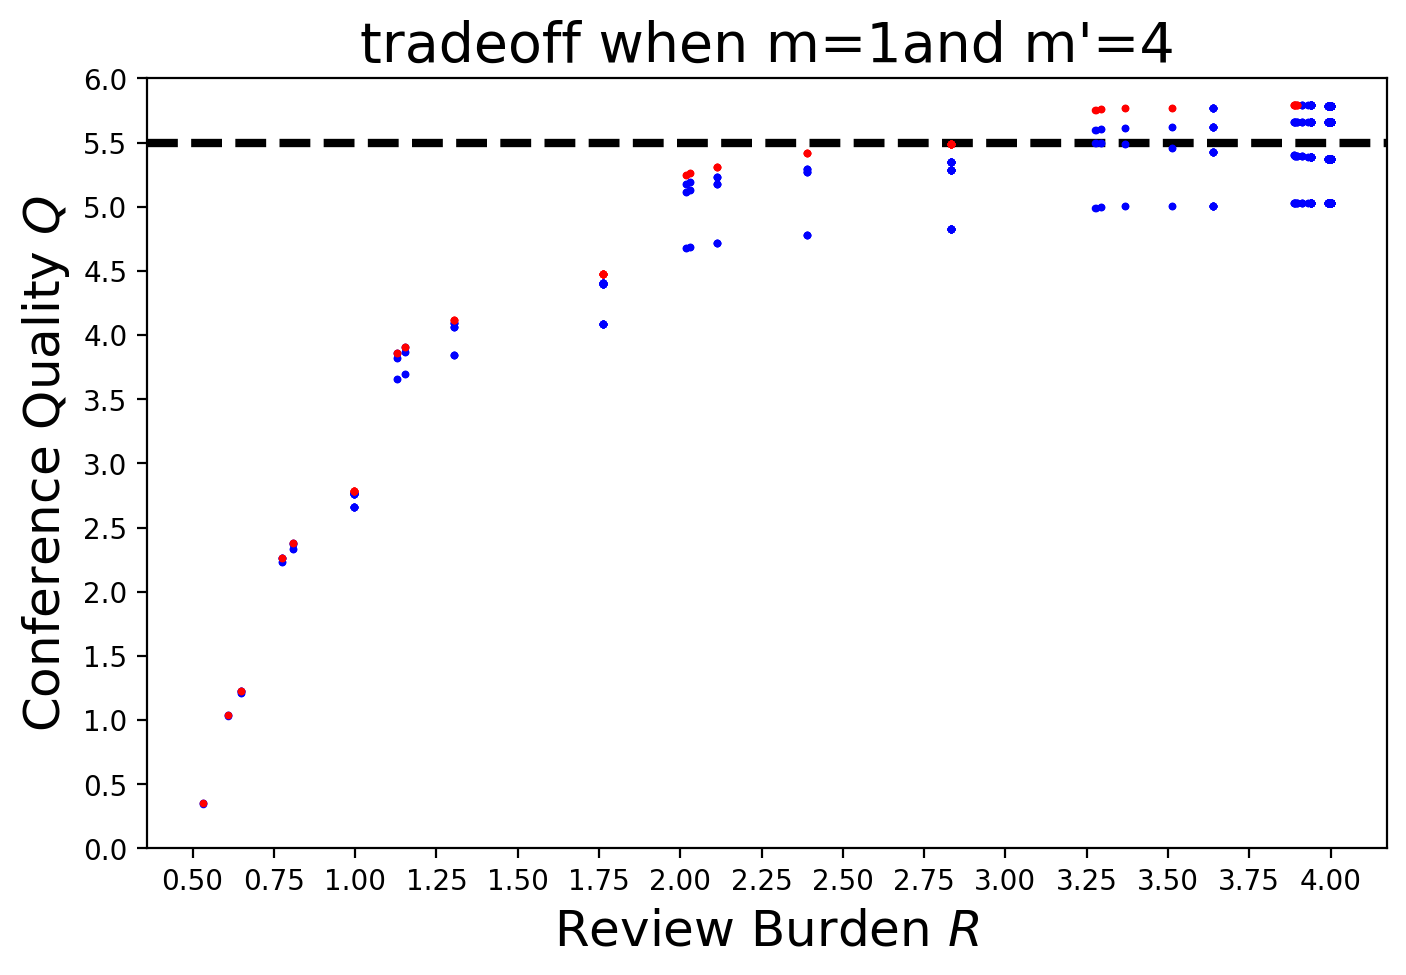

In [146]:
two_phase_experiment(1, 4)

0.9999994266968336
0.07463630180578805
2.0 2.0 5.0
2.0 2.0 5.5
2.0 2.0 6.0
2.0 2.0 6.5
2.0 2.4 5.0
2.0 2.4 5.5
2.0 2.4 6.0
2.0 2.4 6.5
2.0 2.8 5.0
2.0 2.8 5.5
2.0 2.8 6.0
2.0 2.8 6.5
2.0 3.1999999999999997 5.0
2.0 3.1999999999999997 5.5
2.0 3.1999999999999997 6.0
2.0 3.1999999999999997 6.5
2.0 3.5999999999999996 5.0
2.0 3.5999999999999996 5.5
2.0 3.5999999999999996 6.0
2.0 3.5999999999999996 6.5
2.0 3.9999999999999996 5.0
2.0 3.9999999999999996 5.5
2.0 3.9999999999999996 6.0
2.0 3.9999999999999996 6.5
2.0 4.3999999999999995 5.0
2.0 4.3999999999999995 5.5
2.0 4.3999999999999995 6.0
2.0 4.3999999999999995 6.5
2.0 4.799999999999999 5.0
2.0 4.799999999999999 5.5
2.0 4.799999999999999 6.0
2.0 4.799999999999999 6.5
2.0 5.199999999999999 5.0
2.0 5.199999999999999 5.5
2.0 5.199999999999999 6.0
2.0 5.199999999999999 6.5
2.0 5.6 5.0
2.0 5.6 5.5
2.0 5.6 6.0
2.0 5.6 6.5
2.0 5.999999999999999 5.0
2.0 5.999999999999999 5.5
2.0 5.999999999999999 6.0
2.0 5.999999999999999 6.5
2.0 6.399999999999999 5.0

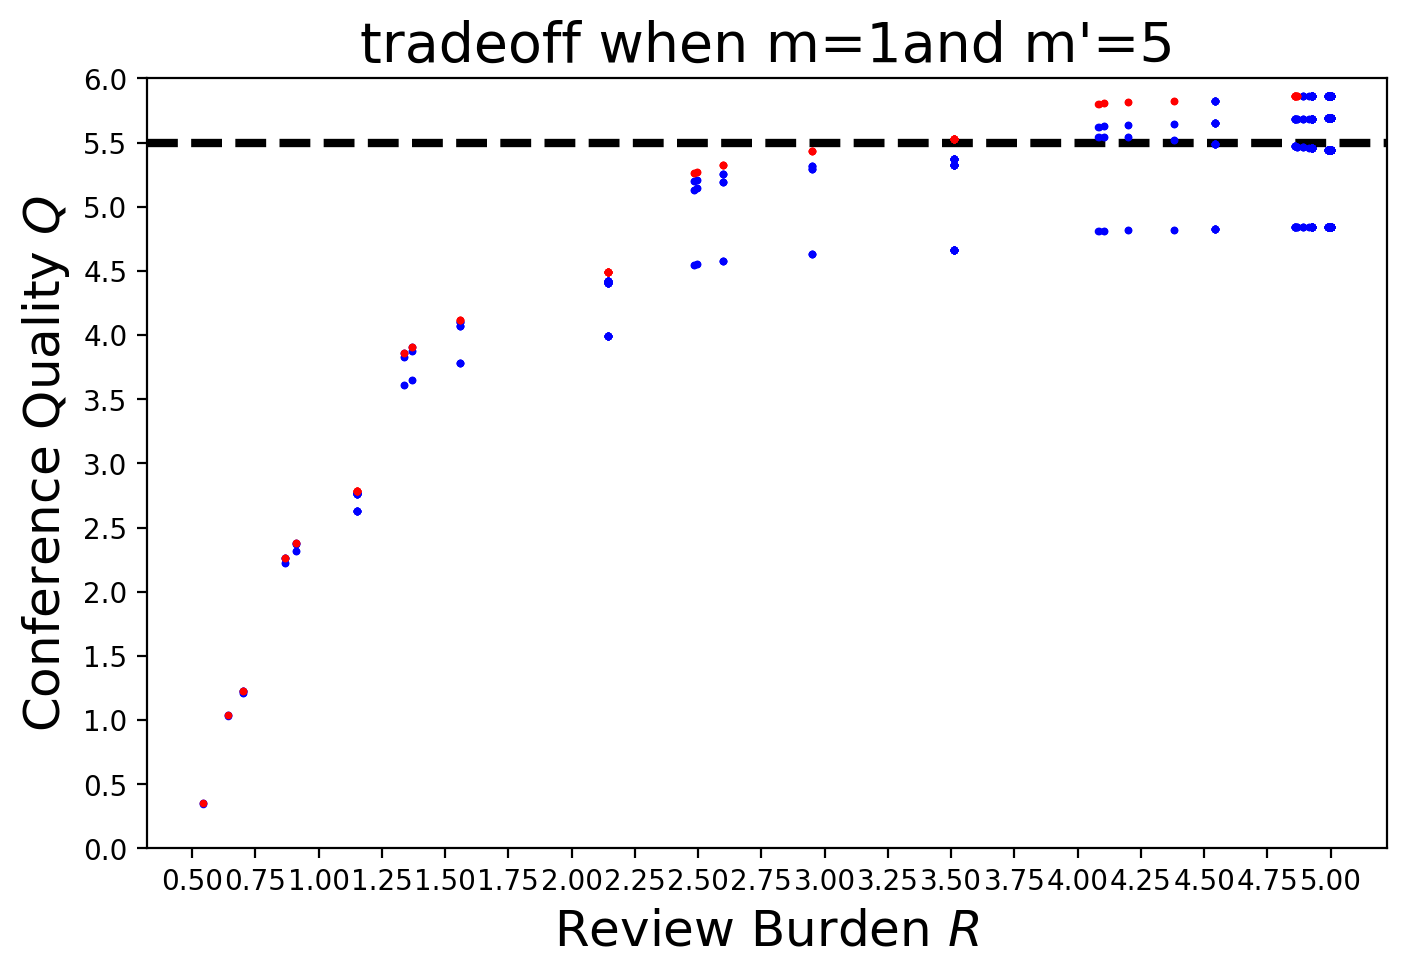

In [147]:
two_phase_experiment(1, 5)

0.6442767405485555
0.3430238783951724
2.0 2.0 5.0
2.0 2.0 5.5
2.0 2.0 6.0
2.0 2.0 6.5
2.0 2.4 5.0
2.0 2.4 5.5
2.0 2.4 6.0
2.0 2.4 6.5
2.0 2.8 5.0
2.0 2.8 5.5
2.0 2.8 6.0
2.0 2.8 6.5
2.0 3.1999999999999997 5.0
2.0 3.1999999999999997 5.5
2.0 3.1999999999999997 6.0
2.0 3.1999999999999997 6.5
2.0 3.5999999999999996 5.0
2.0 3.5999999999999996 5.5
2.0 3.5999999999999996 6.0
2.0 3.5999999999999996 6.5
2.0 3.9999999999999996 5.0
2.0 3.9999999999999996 5.5
2.0 3.9999999999999996 6.0
2.0 3.9999999999999996 6.5
2.0 4.3999999999999995 5.0
2.0 4.3999999999999995 5.5
2.0 4.3999999999999995 6.0
2.0 4.3999999999999995 6.5
2.0 4.799999999999999 5.0
2.0 4.799999999999999 5.5
2.0 4.799999999999999 6.0
2.0 4.799999999999999 6.5
2.0 5.199999999999999 5.0
2.0 5.199999999999999 5.5
2.0 5.199999999999999 6.0
2.0 5.199999999999999 6.5
2.0 5.6 5.0
2.0 5.6 5.5
2.0 5.6 6.0
2.0 5.6 6.5
2.0 5.999999999999999 5.0
2.0 5.999999999999999 5.5
2.0 5.999999999999999 6.0
2.0 5.999999999999999 6.5
2.0 6.399999999999999 5.0


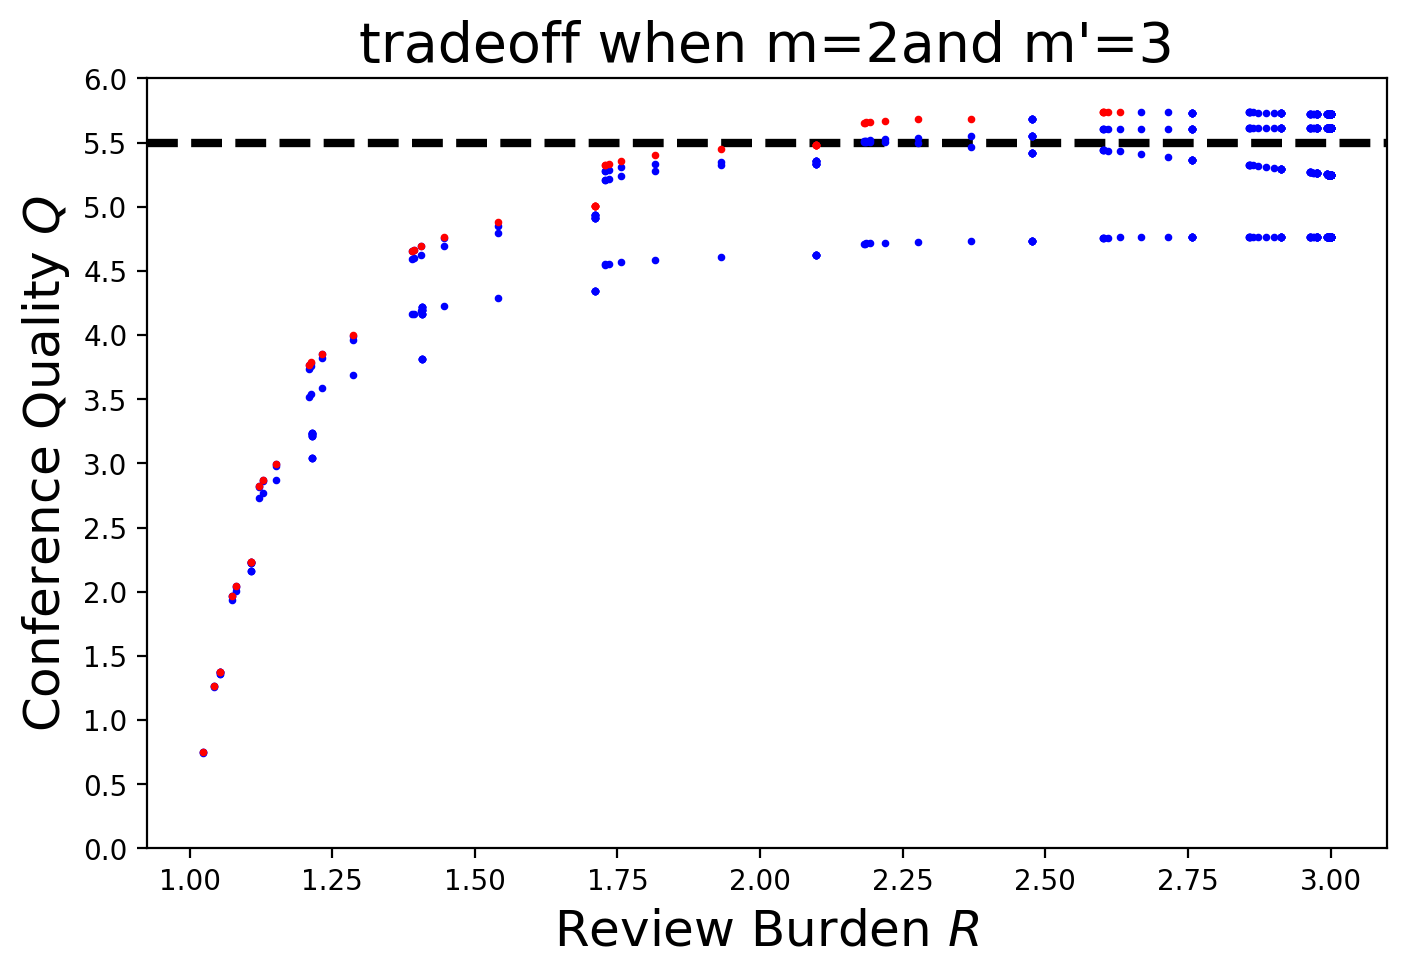

In [148]:
two_phase_experiment(2, 3)

0.6442767405485555
0.164887878506987
2.0 2.0 5.0
2.0 2.0 5.5
2.0 2.0 6.0
2.0 2.0 6.5
2.0 2.4 5.0
2.0 2.4 5.5
2.0 2.4 6.0
2.0 2.4 6.5
2.0 2.8 5.0
2.0 2.8 5.5
2.0 2.8 6.0
2.0 2.8 6.5
2.0 3.1999999999999997 5.0
2.0 3.1999999999999997 5.5
2.0 3.1999999999999997 6.0
2.0 3.1999999999999997 6.5
2.0 3.5999999999999996 5.0
2.0 3.5999999999999996 5.5
2.0 3.5999999999999996 6.0
2.0 3.5999999999999996 6.5
2.0 3.9999999999999996 5.0
2.0 3.9999999999999996 5.5
2.0 3.9999999999999996 6.0
2.0 3.9999999999999996 6.5
2.0 4.3999999999999995 5.0
2.0 4.3999999999999995 5.5
2.0 4.3999999999999995 6.0
2.0 4.3999999999999995 6.5
2.0 4.799999999999999 5.0
2.0 4.799999999999999 5.5
2.0 4.799999999999999 6.0
2.0 4.799999999999999 6.5
2.0 5.199999999999999 5.0
2.0 5.199999999999999 5.5
2.0 5.199999999999999 6.0
2.0 5.199999999999999 6.5
2.0 5.6 5.0
2.0 5.6 5.5
2.0 5.6 6.0
2.0 5.6 6.5
2.0 5.999999999999999 5.0
2.0 5.999999999999999 5.5
2.0 5.999999999999999 6.0
2.0 5.999999999999999 6.5
2.0 6.399999999999999 5.0
2

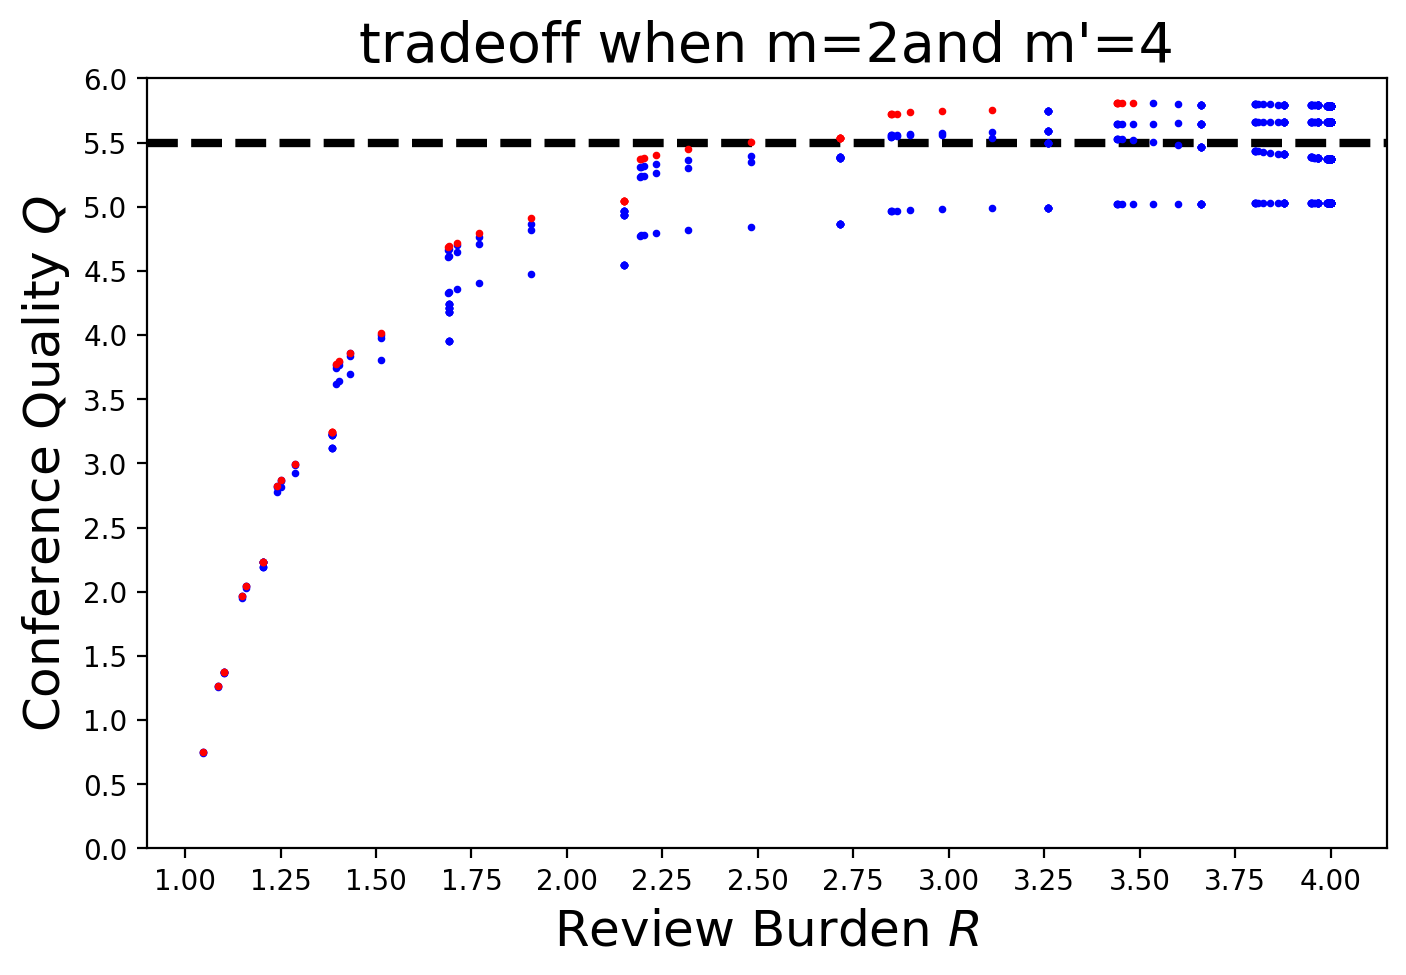

In [149]:
two_phase_experiment(2, 4)

0.6442767405485555
0.07463630180578805
2.0 2.0 5.0
2.0 2.0 5.5
2.0 2.0 6.0
2.0 2.0 6.5
2.0 2.4 5.0
2.0 2.4 5.5
2.0 2.4 6.0
2.0 2.4 6.5
2.0 2.8 5.0
2.0 2.8 5.5
2.0 2.8 6.0
2.0 2.8 6.5
2.0 3.1999999999999997 5.0
2.0 3.1999999999999997 5.5
2.0 3.1999999999999997 6.0
2.0 3.1999999999999997 6.5
2.0 3.5999999999999996 5.0
2.0 3.5999999999999996 5.5
2.0 3.5999999999999996 6.0
2.0 3.5999999999999996 6.5
2.0 3.9999999999999996 5.0
2.0 3.9999999999999996 5.5
2.0 3.9999999999999996 6.0
2.0 3.9999999999999996 6.5
2.0 4.3999999999999995 5.0
2.0 4.3999999999999995 5.5
2.0 4.3999999999999995 6.0
2.0 4.3999999999999995 6.5
2.0 4.799999999999999 5.0
2.0 4.799999999999999 5.5
2.0 4.799999999999999 6.0
2.0 4.799999999999999 6.5
2.0 5.199999999999999 5.0
2.0 5.199999999999999 5.5
2.0 5.199999999999999 6.0
2.0 5.199999999999999 6.5
2.0 5.6 5.0
2.0 5.6 5.5
2.0 5.6 6.0
2.0 5.6 6.5
2.0 5.999999999999999 5.0
2.0 5.999999999999999 5.5
2.0 5.999999999999999 6.0
2.0 5.999999999999999 6.5
2.0 6.399999999999999 5.0

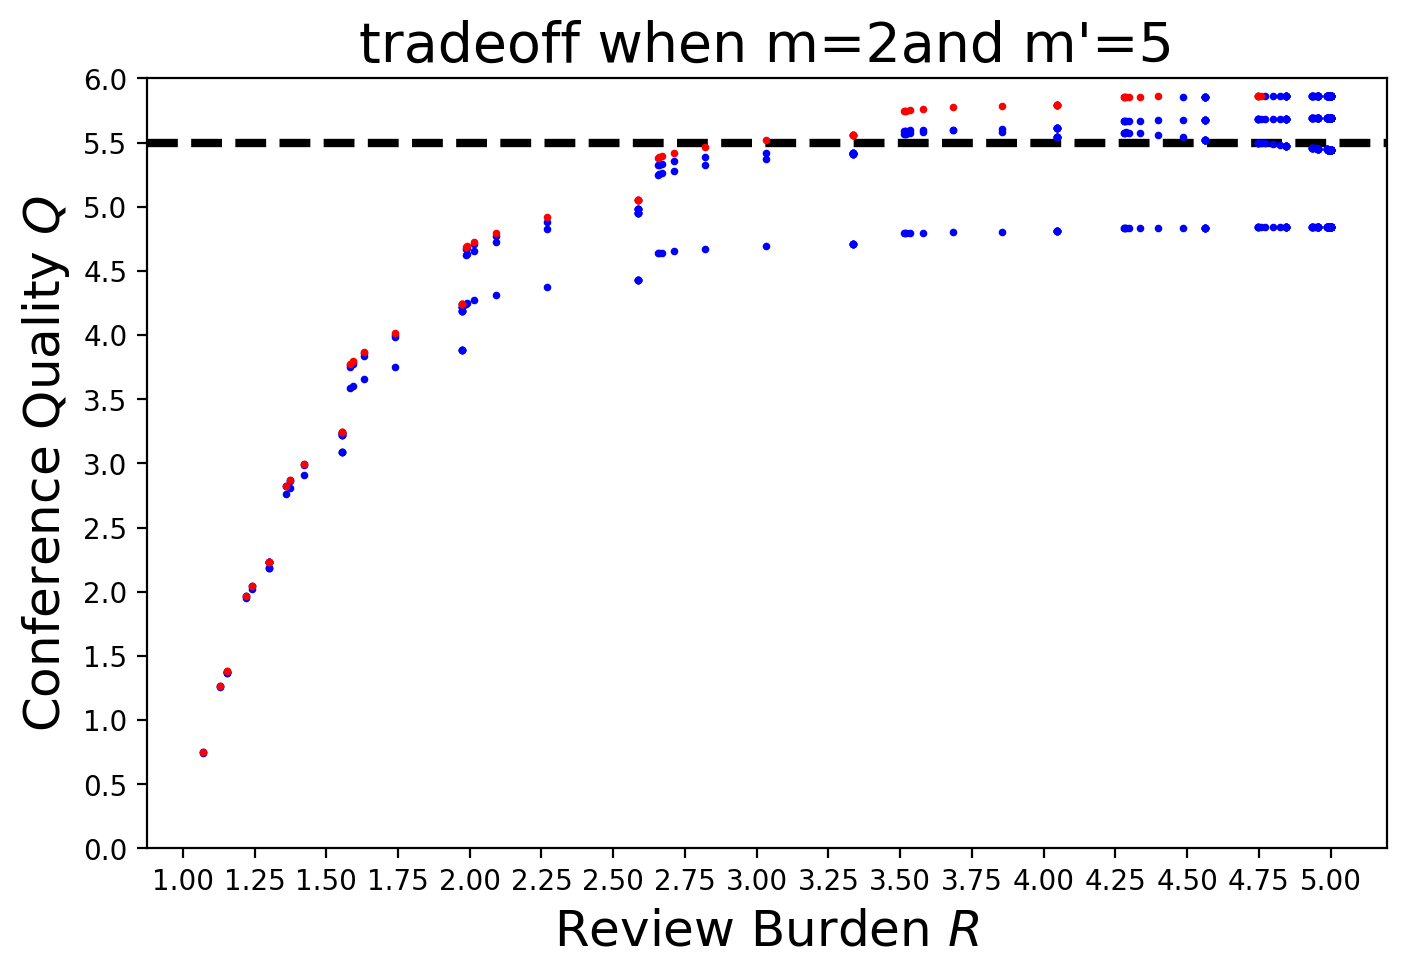

In [150]:
two_phase_experiment(2, 5)

0.3430238783951724
0.164887878506987
2.0 2.0 5.0
2.0 2.0 5.5
2.0 2.0 6.0
2.0 2.0 6.5
2.0 2.4 5.0
2.0 2.4 5.5
2.0 2.4 6.0
2.0 2.4 6.5
2.0 2.8 5.0
2.0 2.8 5.5
2.0 2.8 6.0
2.0 2.8 6.5
2.0 3.1999999999999997 5.0
2.0 3.1999999999999997 5.5
2.0 3.1999999999999997 6.0
2.0 3.1999999999999997 6.5
2.0 3.5999999999999996 5.0
2.0 3.5999999999999996 5.5
2.0 3.5999999999999996 6.0
2.0 3.5999999999999996 6.5
2.0 3.9999999999999996 5.0
2.0 3.9999999999999996 5.5
2.0 3.9999999999999996 6.0
2.0 3.9999999999999996 6.5
2.0 4.3999999999999995 5.0
2.0 4.3999999999999995 5.5
2.0 4.3999999999999995 6.0
2.0 4.3999999999999995 6.5
2.0 4.799999999999999 5.0
2.0 4.799999999999999 5.5
2.0 4.799999999999999 6.0
2.0 4.799999999999999 6.5
2.0 5.199999999999999 5.0
2.0 5.199999999999999 5.5
2.0 5.199999999999999 6.0
2.0 5.199999999999999 6.5
2.0 5.6 5.0
2.0 5.6 5.5
2.0 5.6 6.0
2.0 5.6 6.5
2.0 5.999999999999999 5.0
2.0 5.999999999999999 5.5
2.0 5.999999999999999 6.0
2.0 5.999999999999999 6.5
2.0 6.399999999999999 5.0
2

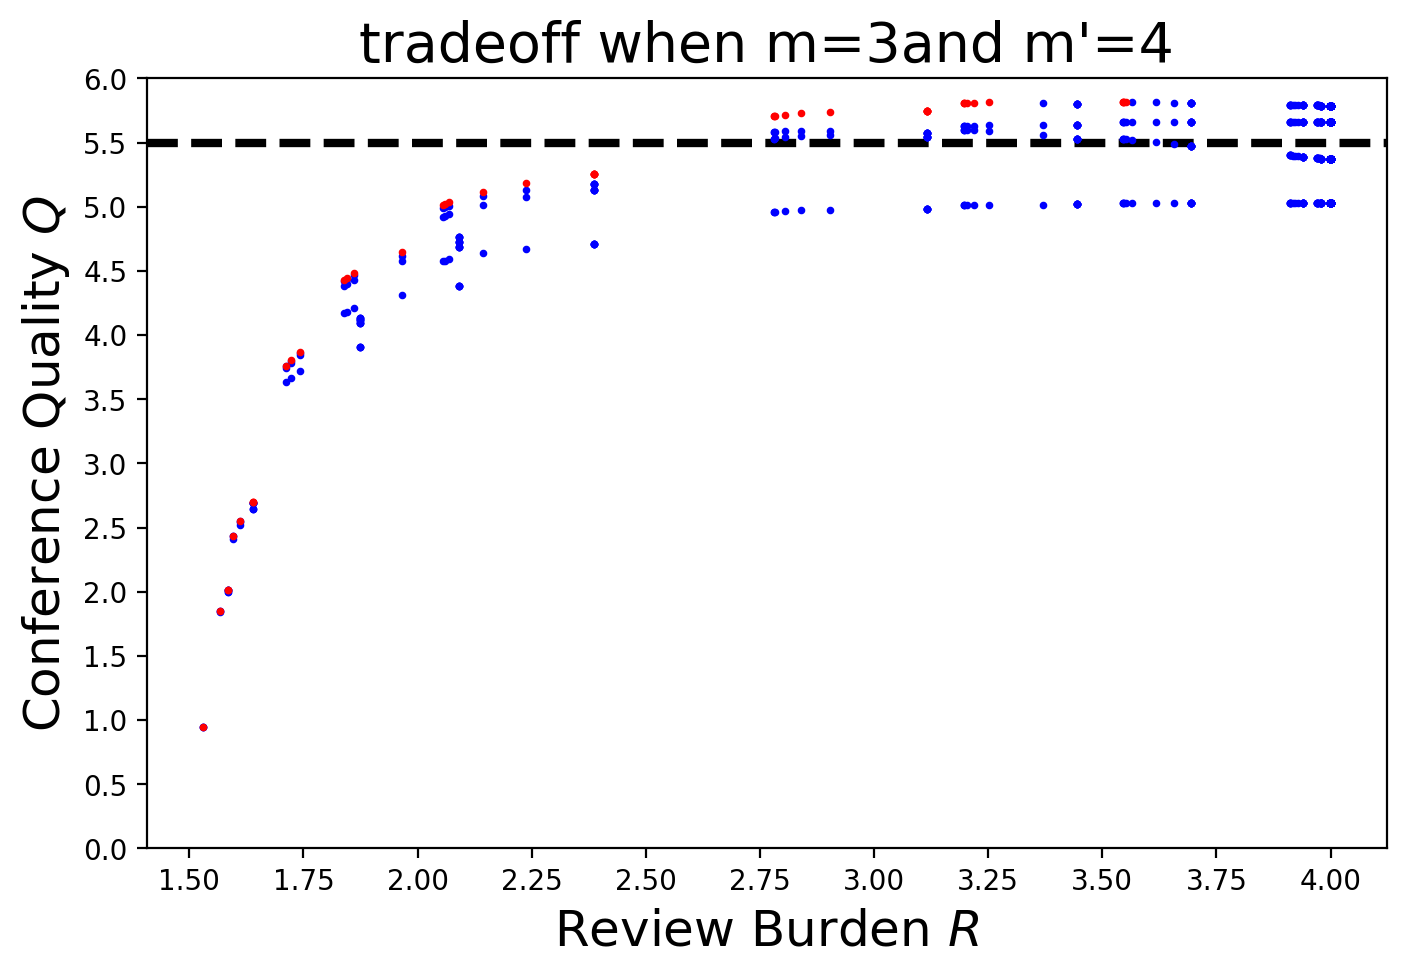

In [151]:
two_phase_experiment(3, 4)

0.3430238783951724
0.07463630180578805
2.0 2.0 5.0
2.0 2.0 5.5
2.0 2.0 6.0
2.0 2.0 6.5
2.0 2.4 5.0
2.0 2.4 5.5
2.0 2.4 6.0
2.0 2.4 6.5
2.0 2.8 5.0
2.0 2.8 5.5
2.0 2.8 6.0
2.0 2.8 6.5
2.0 3.1999999999999997 5.0
2.0 3.1999999999999997 5.5
2.0 3.1999999999999997 6.0
2.0 3.1999999999999997 6.5
2.0 3.5999999999999996 5.0
2.0 3.5999999999999996 5.5
2.0 3.5999999999999996 6.0
2.0 3.5999999999999996 6.5
2.0 3.9999999999999996 5.0
2.0 3.9999999999999996 5.5
2.0 3.9999999999999996 6.0
2.0 3.9999999999999996 6.5
2.0 4.3999999999999995 5.0
2.0 4.3999999999999995 5.5
2.0 4.3999999999999995 6.0
2.0 4.3999999999999995 6.5
2.0 4.799999999999999 5.0
2.0 4.799999999999999 5.5
2.0 4.799999999999999 6.0
2.0 4.799999999999999 6.5
2.0 5.199999999999999 5.0
2.0 5.199999999999999 5.5
2.0 5.199999999999999 6.0
2.0 5.199999999999999 6.5
2.0 5.6 5.0
2.0 5.6 5.5
2.0 5.6 6.0
2.0 5.6 6.5
2.0 5.999999999999999 5.0
2.0 5.999999999999999 5.5
2.0 5.999999999999999 6.0
2.0 5.999999999999999 6.5
2.0 6.399999999999999 5.0

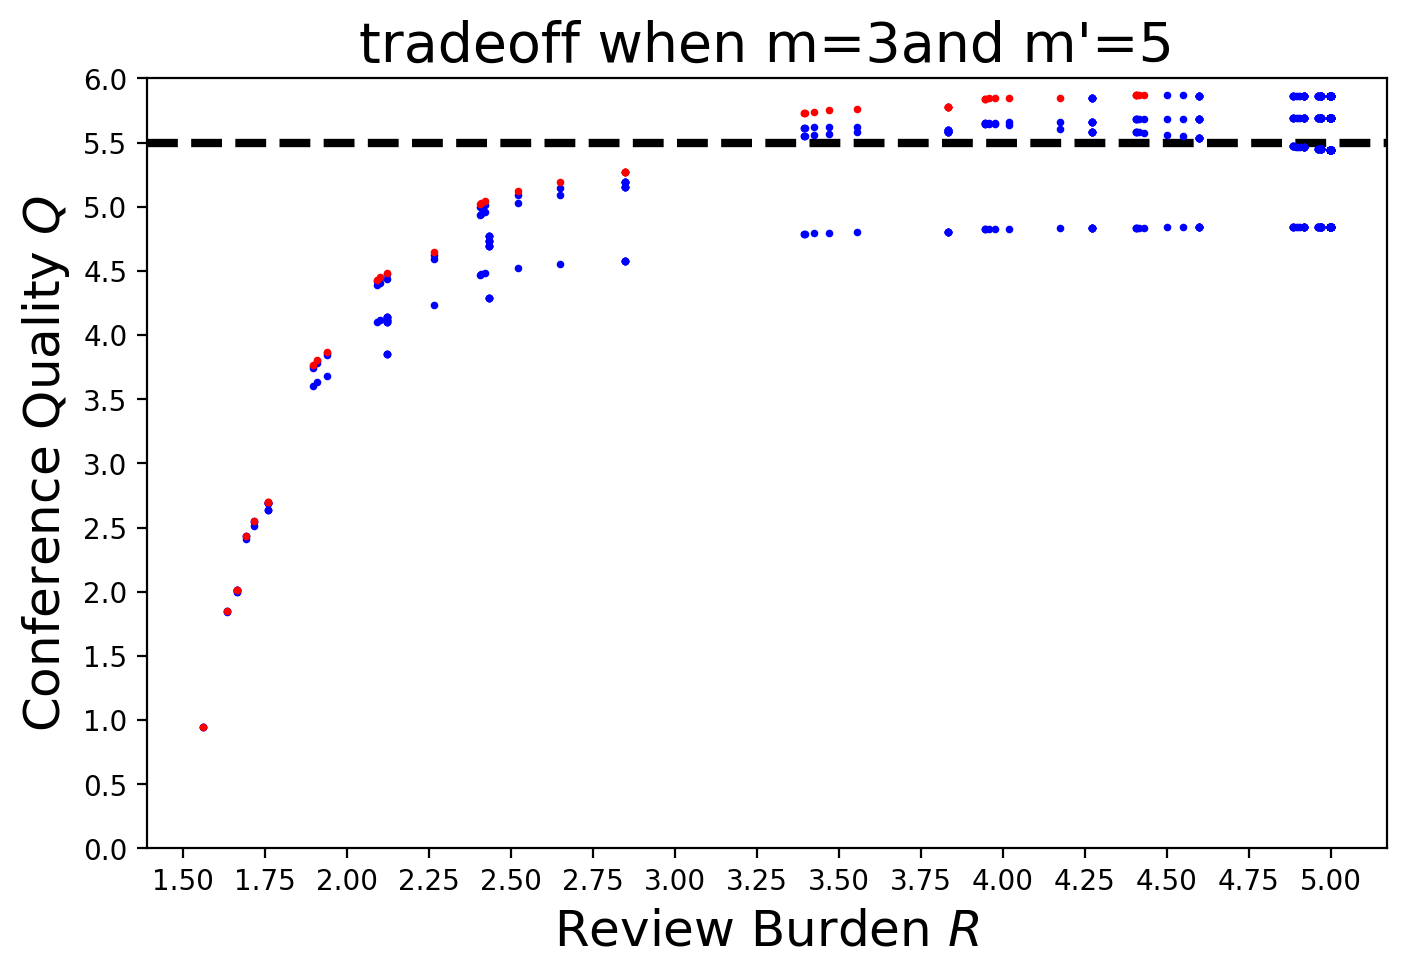

In [152]:
two_phase_experiment(3, 5)

0.3430238783951724
0.032577303637953
2.0 2.0 5.0
2.0 2.0 5.5
2.0 2.0 6.0
2.0 2.0 6.5
2.0 2.4 5.0
2.0 2.4 5.5
2.0 2.4 6.0
2.0 2.4 6.5
2.0 2.8 5.0
2.0 2.8 5.5
2.0 2.8 6.0
2.0 2.8 6.5
2.0 3.1999999999999997 5.0
2.0 3.1999999999999997 5.5
2.0 3.1999999999999997 6.0
2.0 3.1999999999999997 6.5
2.0 3.5999999999999996 5.0
2.0 3.5999999999999996 5.5
2.0 3.5999999999999996 6.0
2.0 3.5999999999999996 6.5
2.0 3.9999999999999996 5.0
2.0 3.9999999999999996 5.5
2.0 3.9999999999999996 6.0
2.0 3.9999999999999996 6.5
2.0 4.3999999999999995 5.0
2.0 4.3999999999999995 5.5
2.0 4.3999999999999995 6.0
2.0 4.3999999999999995 6.5
2.0 4.799999999999999 5.0
2.0 4.799999999999999 5.5
2.0 4.799999999999999 6.0
2.0 4.799999999999999 6.5
2.0 5.199999999999999 5.0
2.0 5.199999999999999 5.5
2.0 5.199999999999999 6.0
2.0 5.199999999999999 6.5
2.0 5.6 5.0
2.0 5.6 5.5
2.0 5.6 6.0
2.0 5.6 6.5
2.0 5.999999999999999 5.0
2.0 5.999999999999999 5.5
2.0 5.999999999999999 6.0
2.0 5.999999999999999 6.5
2.0 6.399999999999999 5.0
2

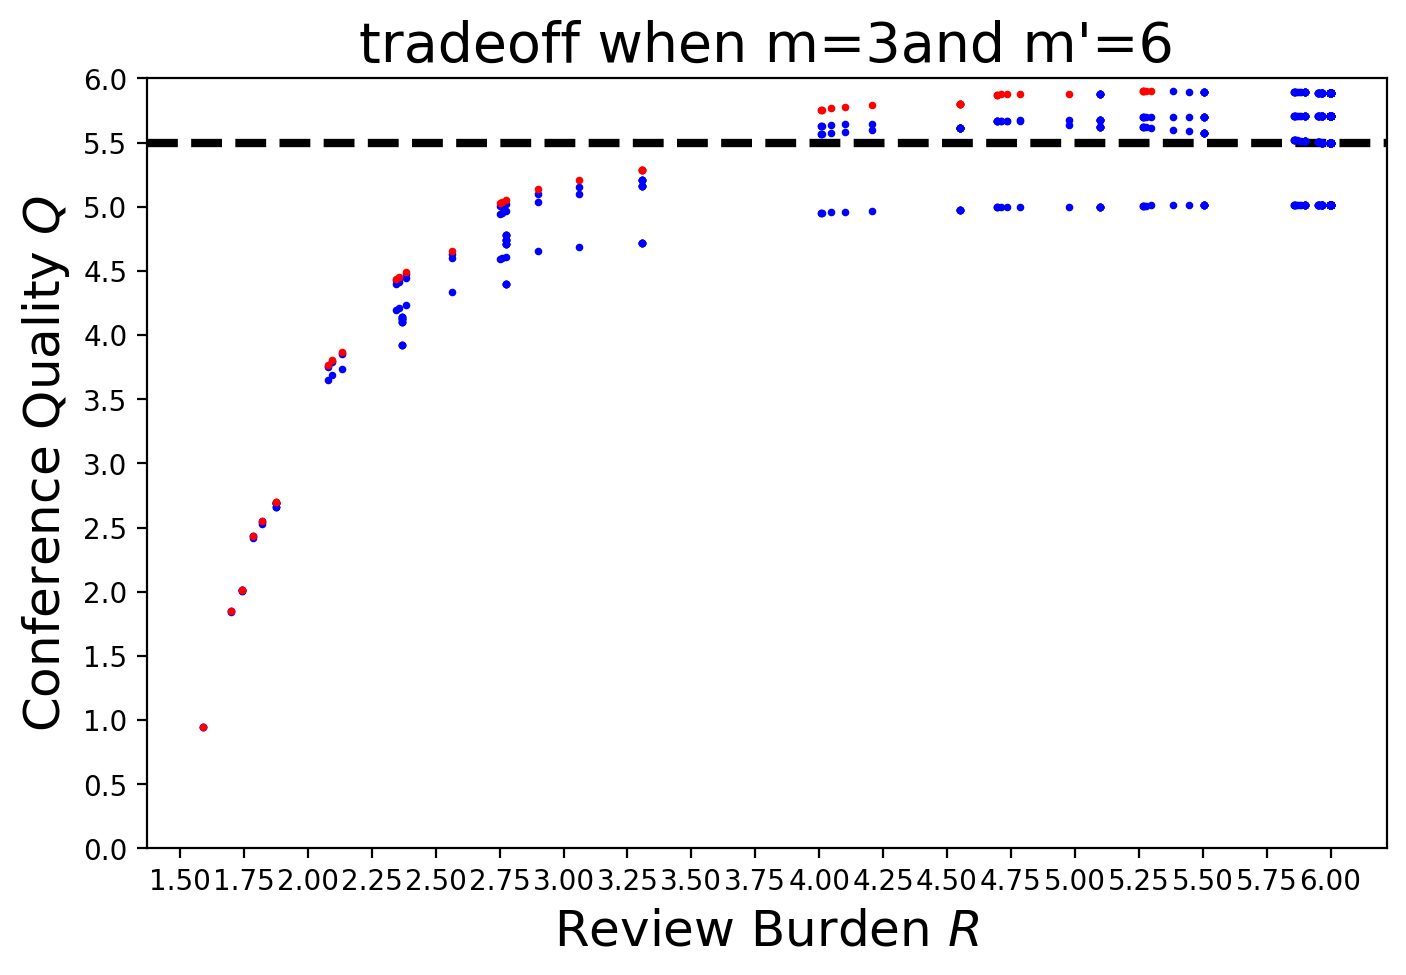

In [153]:
two_phase_experiment(3, 6)

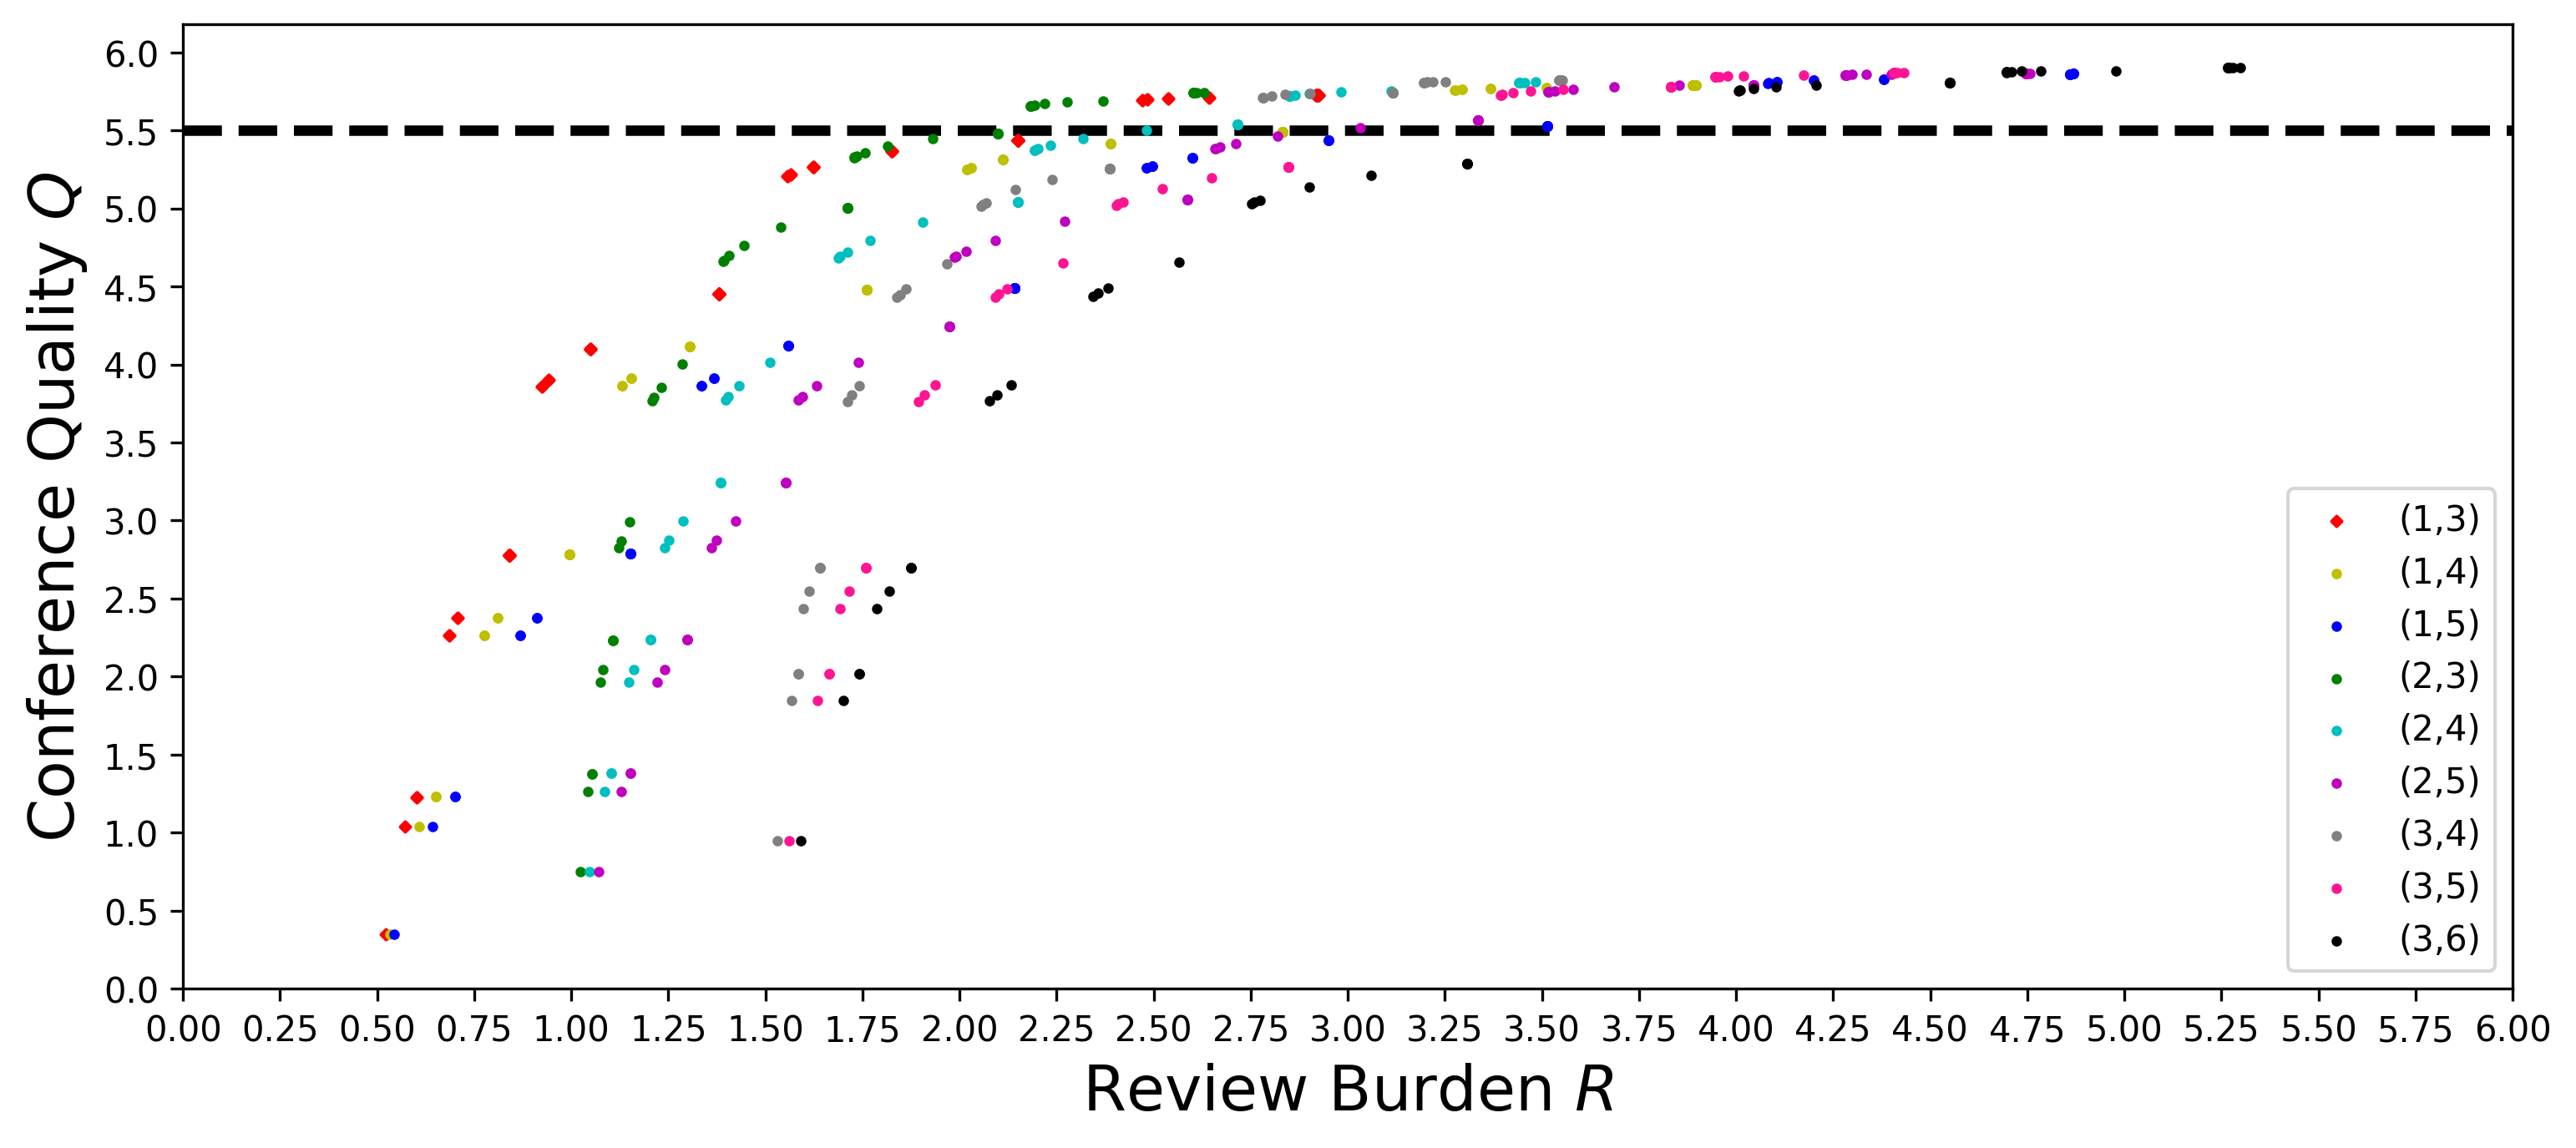

In [154]:
# draw_pareto_optimal
plt.figure(dpi=300, figsize=(12,5))

siz = 4

x = np.load('m13b.npy')
y = np.load('m13q.npy')
plt.scatter(x,y,siz,'r','D',label='(1,3)')

x = np.load('m14b.npy')
y = np.load('m14q.npy')
plt.scatter(x,y,siz,'y',label='(1,4)')

x = np.load('m15b.npy')
y = np.load('m15q.npy')
plt.scatter(x,y,siz,'b',label='(1,5)')

x = np.load('m23b.npy')
y = np.load('m23q.npy')
plt.scatter(x,y,siz,'g',label='(2,3)')

x = np.load('m24b.npy')
y = np.load('m24q.npy')
plt.scatter(x,y,siz,'c',label='(2,4)')

x = np.load('m25b.npy')
y = np.load('m25q.npy')
plt.scatter(x,y,siz,'m',label='(2,5)')

x = np.load('m34b.npy')
y = np.load('m34q.npy')
plt.scatter(x,y,siz,'grey',label='(3,4)')

x = np.load('m35b.npy')
y = np.load('m35q.npy')
plt.scatter(x,y,siz,'deeppink',label='(3,5)')

x = np.load('m36b.npy')
y = np.load('m36q.npy')
plt.scatter(x,y,siz,'k',label='(3,6)')

plt.xlabel(r"Review Burden $R$",fontsize=18)
plt.ylabel(r"Conference Quality $Q$", fontsize=18)
plt.axhline(y=5.5, color='black', linestyle='--', linewidth = 3,zorder=0)
plt.yticks(np.arange(0,6.1,0.5))
plt.xticks(np.arange(0,6.1,0.25))

plt.legend()
plt.show()

In [155]:
print(q_samples)

[[8.28607471 7.12598191 6.72979017 ... 3.91753949 3.53052383 3.16699272]
 [8.64603429 7.2773255  6.51864234 ... 4.96298766 4.5590641  4.14612339]
 [6.885618   6.07240561 6.05669339 ... 3.52711535 3.42071865 2.96802356]
 ...
 [7.38629526 6.03878487 5.18784215 ... 4.66112916 4.41613489 3.06319396]
 [9.69753427 6.1089309  5.78734179 ... 4.98856944 3.99402849 2.22855448]
 [8.18504349 7.44168646 7.37110938 ... 5.24339114 3.38265564 2.34065581]]


In [157]:
print(np.random.normal(5.5,1.5,(10,5)))

[[4.64051503 6.97150415 7.04576738 5.87179595 5.93915769]
 [4.60890146 6.011023   6.07360529 6.84475571 4.99055519]
 [7.52913264 2.54693276 7.05270265 7.12238782 1.43219984]
 [4.32037108 5.57538127 4.44700123 5.12401909 6.82404412]
 [4.63272336 5.67509941 8.74683813 3.87562194 5.30966798]
 [7.86007722 7.05591927 6.49883261 4.6332314  8.44924916]
 [4.93395319 4.0450579  4.67980277 4.94888659 6.22127114]
 [5.74870779 6.24133843 1.98843867 4.35987983 6.28989063]
 [4.0554904  6.62740512 4.48959819 6.98681676 4.98857862]
 [7.81168067 4.41821915 5.40689322 5.684994   6.09006389]]


In [158]:
old_samples = q_samples

In [242]:
#paper_number_distribution = [0, 659, 177, 73, 27, 26, 10, 8, 20]
paper_number_distribution = [0, 1, 1, 1, 1, 1, 1, 1, 1000]
paper_total_number = 0
for i in range(1, 9):
    paper_number_distribution[i] *= 1
    paper_total_number += i * paper_number_distribution[i]
print(paper_total_number)
all_samples = np.random.normal(mu_q, sig_q, paper_total_number)
cnt = 0
q_samples_new = {}
for i in range(1, 9):
    q_samples_new[i] = []
    for j in range(0, paper_number_distribution[i]):
        temp = []
        for k in range(0, i):
            temp.append(all_samples[cnt])
            cnt += 1
        q_samples_new[i].append(temp)
    q_samples_new[i] = np.sort(q_samples_new[i], axis = 1, kind='quicksort')[:,::-1]

8028


In [243]:
paper_number_distribution

[0, 1, 1, 1, 1, 1, 1, 1, 1000]

In [246]:
def two_phase_experiment_new(num, num1):
    global m, m1, t1, t2, t_acc, IsComputed, acceptance_probability_q_m, acceptance_probability_q_m_m1, N, n, q_samples
    quality = []
    burden = []
    res = []
    m = num
    m1 = num1
    prior_s_prob_m = compute_s_joint_prob(m)
    prior_s_prob_m1 = compute_s_joint_prob(m1)
    expected_quality_m = Expected_quality_of_combinations(m , prior_s_prob_m)
    t1_range = np.arange(4.0, 7.1, 0.4)
    t2_range = np.arange(4.0, 7.1, 0.4)
    tacc_range = np.arange(4.0, 7.6, 0.5)
    IsComputed = {}
    acceptance_probability_q_m = {}
    acceptance_probability_q_m_m1 = {}
    for ii in range(len(t1_range)):
        for j in range(len(t2_range)):
            for k in range(len(tacc_range)):
                t1 = t1_range[ii]
                t2 = t2_range[j]
                t_acc = tacc_range[k]
                print(t1, t2, t_acc)
                quality_total = 0.0
                burden_total = 0.0
                accept_total = 0.0
                for number in range(1, 9):
                    q_samples = q_samples_new[number]
                    #q_samples = old_samples
                    n = number
                    N = paper_number_distribution[number]
                    #N = 1000
                    phase1_para = RealConfParams(  ## basic parameters are the same as the original and in phase 1 we 
                        n = n,
                        k = m,
                        mu_q = mu_q,
                        sig_q = sig_q,
                        t = t
                    )
                    phase1_acceptance_probability(phase1_para, q_samples[:,0], 1, t1, t2, expected_quality_m)
                    prob_all, prob_per_comb = compute_prob_into_phase2(phase1_para, q_samples, t1, t2, expected_quality_m)
                    phase2_para = phase1_para
                    phase2_para.k = m1
                    final_prob_all = np.copy(prob_all)
                    #print([np.average(final_prob_all[i]) for i in range(n)])
                    for i in range(0, n):
                        if(i< math.ceil(n/2)):
                            prob_i = test_First_half_phase2_acceptance_probability(phase2_para, q_samples[:,i], m, m1, prob_per_comb[i], t_acc)
                        else:
                            prob_i = test_Last_half_phase2_acceptance_probability(phase2_para, q_samples[:,i], t_acc)
                        #print(i,": ",np.average(prob_i))
                        final_prob_all[i] *= prob_i
                    #print([np.average(final_prob_all[i]) for i in range(n)])
                    aver_quality = np.zeros(N)
                    rev_n = np.zeros(N)
                    expected_number = 0.0
                    for i in range(n):
                        aver_quality += (q_samples[:,i]-mu_q)*final_prob_all[i]
                        expected_number += np.sum(final_prob_all[i])
                        #rev_n += m1*final_prob_all[i]+m*(1-(final_prob_all[i]/prob_all[i]))* (1 if i < math.ceil(n/2) else 0)
                        rev_n += (m1*prob_all[i] + m*(1-prob_all[i])*(1 if i < math.ceil(n/2) else 0))
                        quality_total += np.sum((q_samples[:,i])*final_prob_all[i])
                        burden_total += np.sum(m1*prob_all[i] + m*(1-prob_all[i])*(1 if i < math.ceil(n/2) else 0))
                    #print(np.average(aver_quality), np.average(rev_n)/n)
                    #quality_total += np.sum(aver_quality)
                    accept_total += expected_number
                quality.append(quality_total / paper_total_number)
                burden.append(burden_total / paper_total_number)
                res.append((t1,t2,t_acc,accept_total))
    x = []
    y = []
    color = []
    shapes = []
    pareto_x = []
    pareto_y = []
    pareto_res = []
    normal_x = []
    normal_y = []
    pareto_color = []
    normal_color = []
    for i in burden:
        x.append(float(i))
    for i in quality:
        y.append(float(i))
    cnt = 0
    for i in burden:
        flag = 1
        for j in range(len(x)):
            if((x[j]<x[cnt] and y[j]>y[cnt]) or (x[j] == x[cnt] and y[j]>y[cnt]) or (x[j]<x[cnt] and y[j] == y[cnt])):
                flag = 0
        if(flag == 1):
            pareto_x.append(x[cnt])
            pareto_y.append(y[cnt])
            #pareto_color.append(color[cnt])
            pareto_res.append(res[cnt])
        else:
            normal_x.append(x[cnt])
            normal_y.append(y[cnt])
            #normal_color.append(color[cnt])
        cnt += 1
    np.save("m"+str(m)+str(m1)+"b"+"_new", pareto_x)
    np.save("m"+str(m)+str(m1)+"q"+"_new", pareto_y)
    np.save("m"+str(m)+str(m1)+"r"+"_new", pareto_res)
    np.save("m"+str(m)+str(m1)+"x"+"_new", x)
    np.save("m"+str(m)+str(m1)+"y"+"_new", y)
    np.save("m"+str(m)+str(m1)+"a"+"_new", res)
    plt.figure(dpi=200)
    plt.ylim(0,6)
    plt.yticks(np.arange(0,6.1,0.5))
    plt.xticks(np.arange(0,6.1,0.25))
    plt.axhline(y=5.5, color='black', linestyle='--', linewidth = 3,zorder=0)
    #plt.figure(dpi=120)
    plt.scatter(normal_x, normal_y, 3, 'b')
    plt.scatter(pareto_x, pareto_y, 3, 'r')
    plt.xlabel(r"Review Burden $R$",fontsize=18)
    plt.ylabel(r"Conference Quality $Q$", fontsize=18)
    plt.title("tradeoff when m="+str(m) + "and m'="+str(m1),fontsize=20)
    plt.show()

0.9999994266968336
0.3430238783951724
4.0 4.0 4.0
4.0 4.0 4.5
4.0 4.0 5.0
4.0 4.0 5.5
4.0 4.0 6.0
4.0 4.0 6.5
4.0 4.0 7.0
4.0 4.0 7.5
4.0 4.4 4.0
4.0 4.4 4.5
4.0 4.4 5.0
4.0 4.4 5.5
4.0 4.4 6.0
4.0 4.4 6.5
4.0 4.4 7.0
4.0 4.4 7.5
4.0 4.800000000000001 4.0
4.0 4.800000000000001 4.5
4.0 4.800000000000001 5.0
4.0 4.800000000000001 5.5
4.0 4.800000000000001 6.0
4.0 4.800000000000001 6.5
4.0 4.800000000000001 7.0
4.0 4.800000000000001 7.5
4.0 5.200000000000001 4.0
4.0 5.200000000000001 4.5
4.0 5.200000000000001 5.0
4.0 5.200000000000001 5.5
4.0 5.200000000000001 6.0
4.0 5.200000000000001 6.5
4.0 5.200000000000001 7.0
4.0 5.200000000000001 7.5
4.0 5.600000000000001 4.0
4.0 5.600000000000001 4.5
4.0 5.600000000000001 5.0
4.0 5.600000000000001 5.5
4.0 5.600000000000001 6.0
4.0 5.600000000000001 6.5
4.0 5.600000000000001 7.0
4.0 5.600000000000001 7.5
4.0 6.000000000000002 4.0
4.0 6.000000000000002 4.5
4.0 6.000000000000002 5.0
4.0 6.000000000000002 5.5
4.0 6.000000000000002 6.0
4.0 6.0000000000

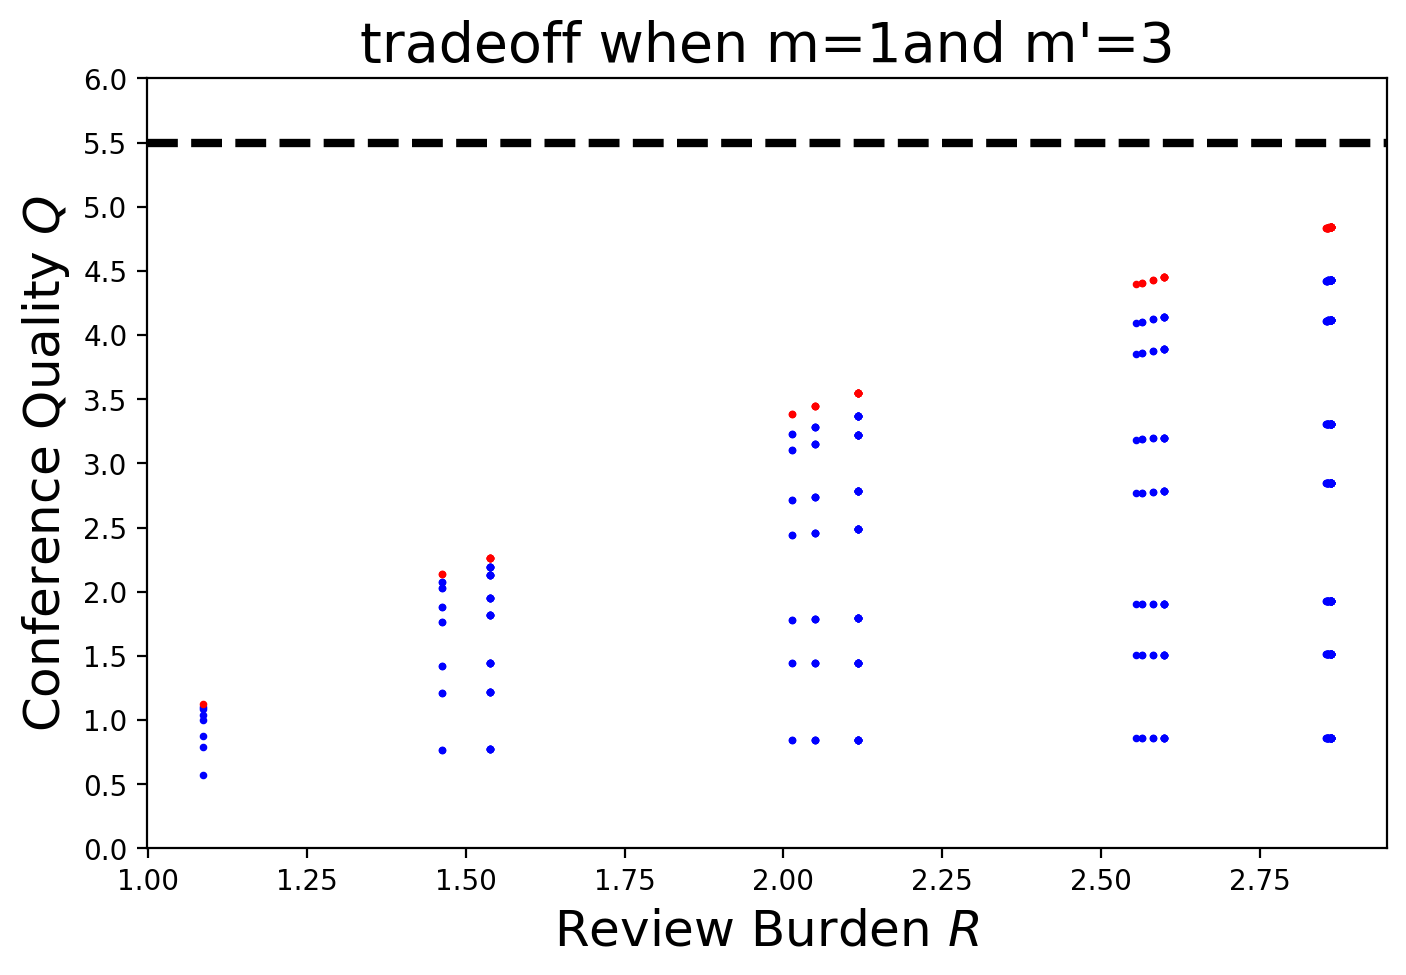

In [232]:
two_phase_experiment_new(1, 3)

0.9999994266968336
0.164887878506987
4.0 4.0 4.0
4.0 4.0 4.5
4.0 4.0 5.0
4.0 4.0 5.5
4.0 4.0 6.0
4.0 4.0 6.5
4.0 4.0 7.0
4.0 4.0 7.5
4.0 4.4 4.0
4.0 4.4 4.5
4.0 4.4 5.0
4.0 4.4 5.5
4.0 4.4 6.0
4.0 4.4 6.5
4.0 4.4 7.0
4.0 4.4 7.5
4.0 4.800000000000001 4.0
4.0 4.800000000000001 4.5
4.0 4.800000000000001 5.0
4.0 4.800000000000001 5.5
4.0 4.800000000000001 6.0
4.0 4.800000000000001 6.5
4.0 4.800000000000001 7.0
4.0 4.800000000000001 7.5
4.0 5.200000000000001 4.0
4.0 5.200000000000001 4.5
4.0 5.200000000000001 5.0
4.0 5.200000000000001 5.5
4.0 5.200000000000001 6.0
4.0 5.200000000000001 6.5
4.0 5.200000000000001 7.0
4.0 5.200000000000001 7.5
4.0 5.600000000000001 4.0
4.0 5.600000000000001 4.5
4.0 5.600000000000001 5.0
4.0 5.600000000000001 5.5
4.0 5.600000000000001 6.0
4.0 5.600000000000001 6.5
4.0 5.600000000000001 7.0
4.0 5.600000000000001 7.5
4.0 6.000000000000002 4.0
4.0 6.000000000000002 4.5
4.0 6.000000000000002 5.0
4.0 6.000000000000002 5.5
4.0 6.000000000000002 6.0
4.0 6.00000000000

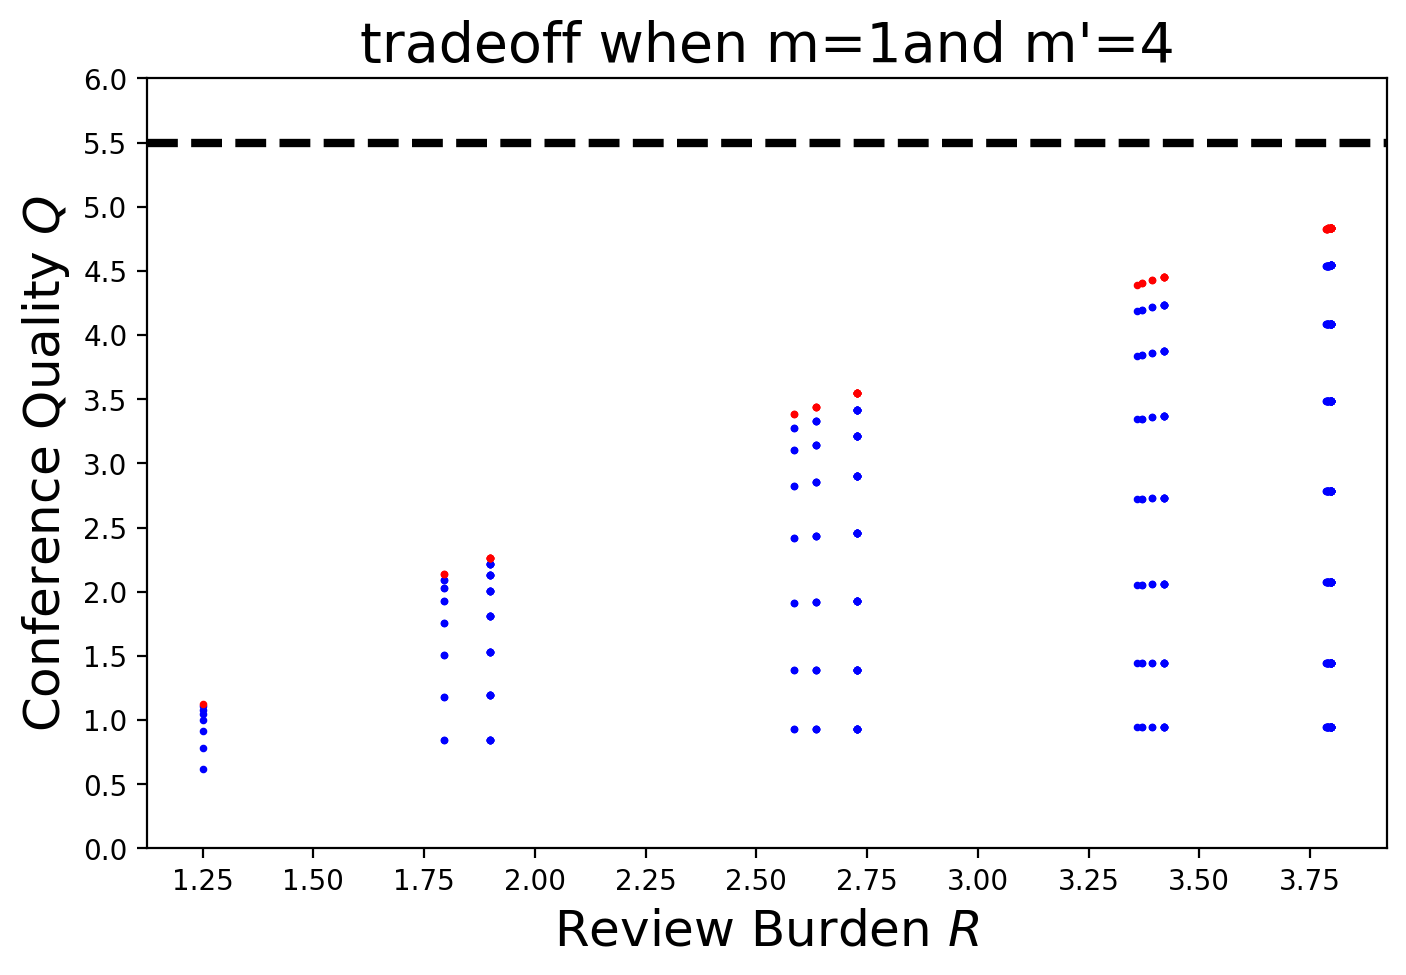

In [233]:
two_phase_experiment_new(1, 4)

0.9999994266968336
0.07463630180578805
4.0 4.0 4.0
4.0 4.0 4.5
4.0 4.0 5.0
4.0 4.0 5.5
4.0 4.0 6.0
4.0 4.0 6.5
4.0 4.0 7.0
4.0 4.0 7.5
4.0 4.4 4.0
4.0 4.4 4.5
4.0 4.4 5.0
4.0 4.4 5.5
4.0 4.4 6.0
4.0 4.4 6.5
4.0 4.4 7.0
4.0 4.4 7.5
4.0 4.800000000000001 4.0
4.0 4.800000000000001 4.5
4.0 4.800000000000001 5.0
4.0 4.800000000000001 5.5
4.0 4.800000000000001 6.0
4.0 4.800000000000001 6.5
4.0 4.800000000000001 7.0
4.0 4.800000000000001 7.5
4.0 5.200000000000001 4.0
4.0 5.200000000000001 4.5
4.0 5.200000000000001 5.0
4.0 5.200000000000001 5.5
4.0 5.200000000000001 6.0
4.0 5.200000000000001 6.5
4.0 5.200000000000001 7.0
4.0 5.200000000000001 7.5
4.0 5.600000000000001 4.0
4.0 5.600000000000001 4.5
4.0 5.600000000000001 5.0
4.0 5.600000000000001 5.5
4.0 5.600000000000001 6.0
4.0 5.600000000000001 6.5
4.0 5.600000000000001 7.0
4.0 5.600000000000001 7.5
4.0 6.000000000000002 4.0
4.0 6.000000000000002 4.5
4.0 6.000000000000002 5.0
4.0 6.000000000000002 5.5
4.0 6.000000000000002 6.0
4.0 6.000000000

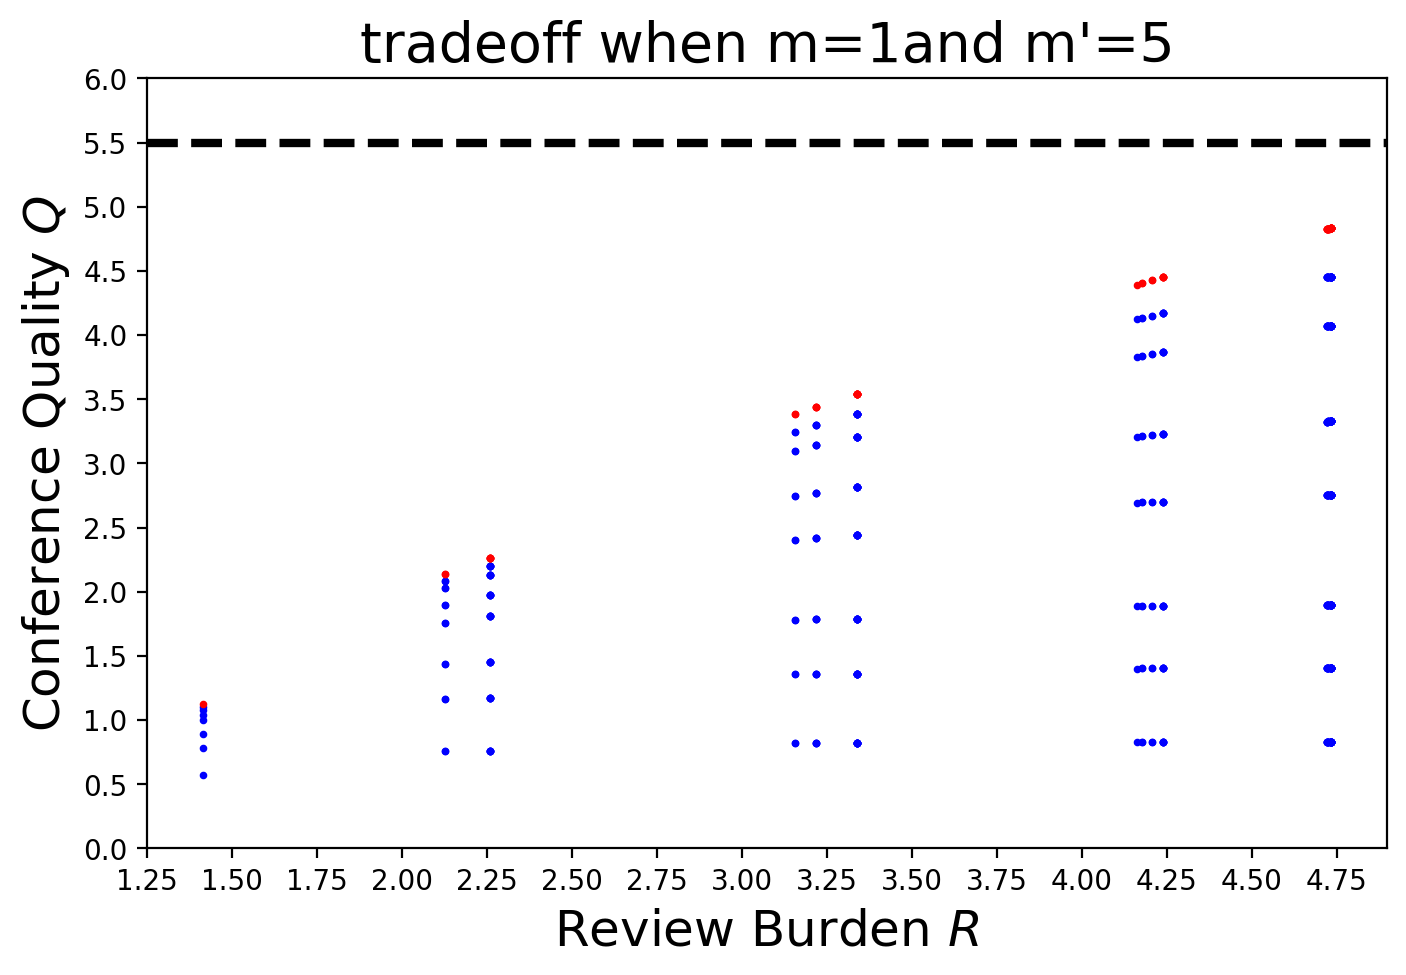

In [234]:
two_phase_experiment_new(1, 5)

0.6442767405485555
0.3430238783951724
4.0 4.0 4.0
4.0 4.0 4.5
4.0 4.0 5.0
4.0 4.0 5.5
4.0 4.0 6.0
4.0 4.0 6.5
4.0 4.0 7.0
4.0 4.0 7.5
4.0 4.4 4.0
4.0 4.4 4.5
4.0 4.4 5.0
4.0 4.4 5.5
4.0 4.4 6.0
4.0 4.4 6.5
4.0 4.4 7.0
4.0 4.4 7.5
4.0 4.800000000000001 4.0
4.0 4.800000000000001 4.5
4.0 4.800000000000001 5.0
4.0 4.800000000000001 5.5
4.0 4.800000000000001 6.0
4.0 4.800000000000001 6.5
4.0 4.800000000000001 7.0
4.0 4.800000000000001 7.5
4.0 5.200000000000001 4.0
4.0 5.200000000000001 4.5
4.0 5.200000000000001 5.0
4.0 5.200000000000001 5.5
4.0 5.200000000000001 6.0
4.0 5.200000000000001 6.5
4.0 5.200000000000001 7.0
4.0 5.200000000000001 7.5
4.0 5.600000000000001 4.0
4.0 5.600000000000001 4.5
4.0 5.600000000000001 5.0
4.0 5.600000000000001 5.5
4.0 5.600000000000001 6.0
4.0 5.600000000000001 6.5
4.0 5.600000000000001 7.0
4.0 5.600000000000001 7.5
4.0 6.000000000000002 4.0
4.0 6.000000000000002 4.5
4.0 6.000000000000002 5.0
4.0 6.000000000000002 5.5
4.0 6.000000000000002 6.0
4.0 6.0000000000

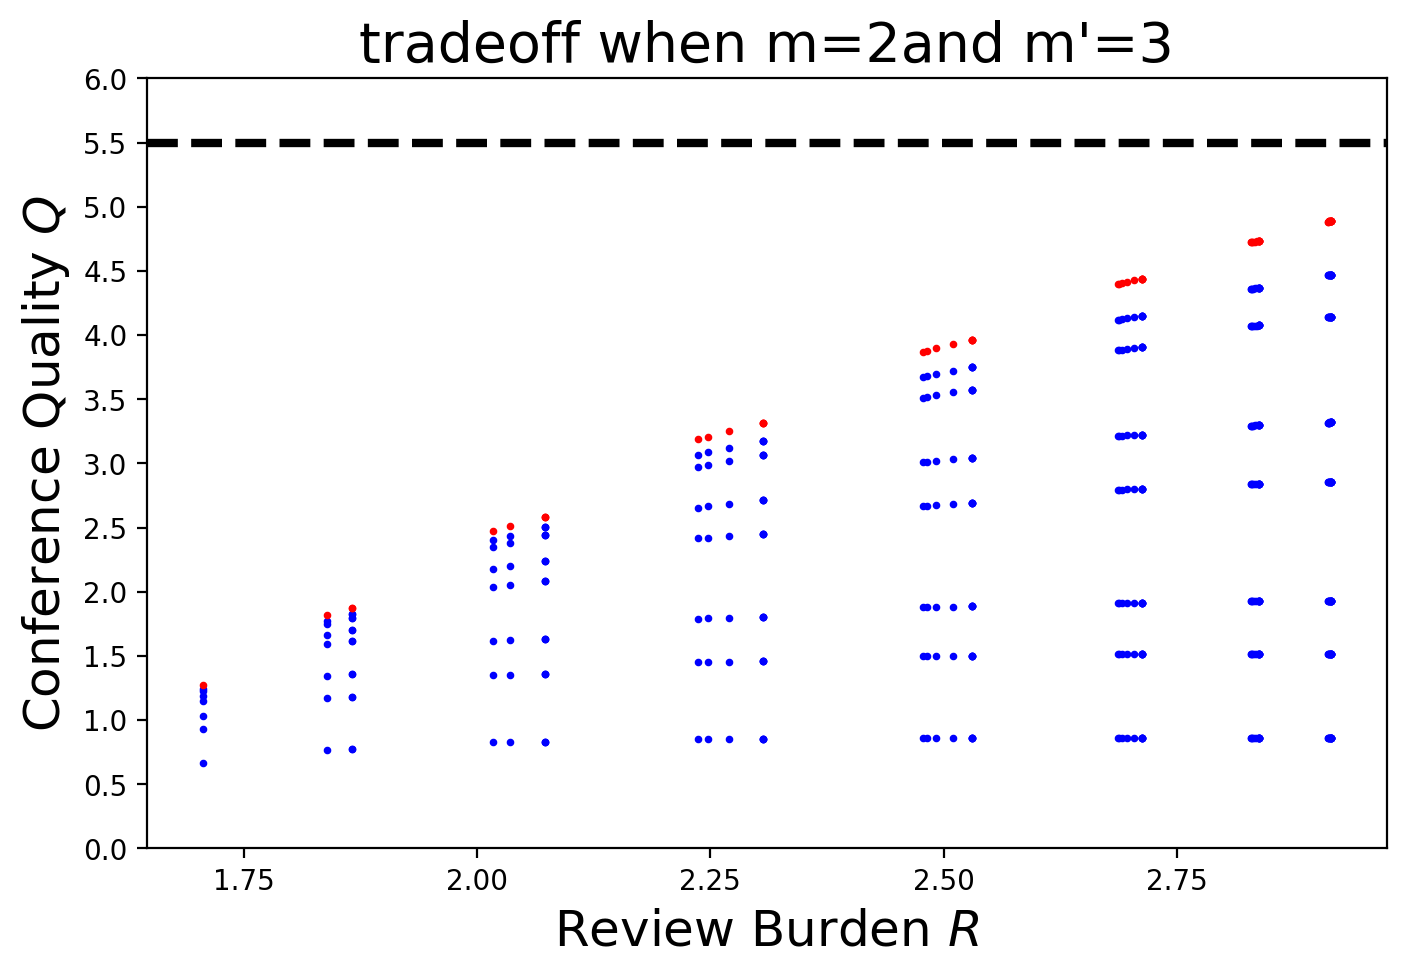

In [235]:
two_phase_experiment_new(2, 3)

0.6442767405485555
0.164887878506987
4.0 4.0 4.0
4.0 4.0 4.5
4.0 4.0 5.0
4.0 4.0 5.5
4.0 4.0 6.0
4.0 4.0 6.5
4.0 4.0 7.0
4.0 4.0 7.5
4.0 4.4 4.0
4.0 4.4 4.5
4.0 4.4 5.0
4.0 4.4 5.5
4.0 4.4 6.0
4.0 4.4 6.5
4.0 4.4 7.0
4.0 4.4 7.5
4.0 4.800000000000001 4.0
4.0 4.800000000000001 4.5
4.0 4.800000000000001 5.0
4.0 4.800000000000001 5.5
4.0 4.800000000000001 6.0
4.0 4.800000000000001 6.5
4.0 4.800000000000001 7.0
4.0 4.800000000000001 7.5
4.0 5.200000000000001 4.0
4.0 5.200000000000001 4.5
4.0 5.200000000000001 5.0
4.0 5.200000000000001 5.5
4.0 5.200000000000001 6.0
4.0 5.200000000000001 6.5
4.0 5.200000000000001 7.0
4.0 5.200000000000001 7.5
4.0 5.600000000000001 4.0
4.0 5.600000000000001 4.5
4.0 5.600000000000001 5.0
4.0 5.600000000000001 5.5
4.0 5.600000000000001 6.0
4.0 5.600000000000001 6.5
4.0 5.600000000000001 7.0
4.0 5.600000000000001 7.5
4.0 6.000000000000002 4.0
4.0 6.000000000000002 4.5
4.0 6.000000000000002 5.0
4.0 6.000000000000002 5.5
4.0 6.000000000000002 6.0
4.0 6.00000000000

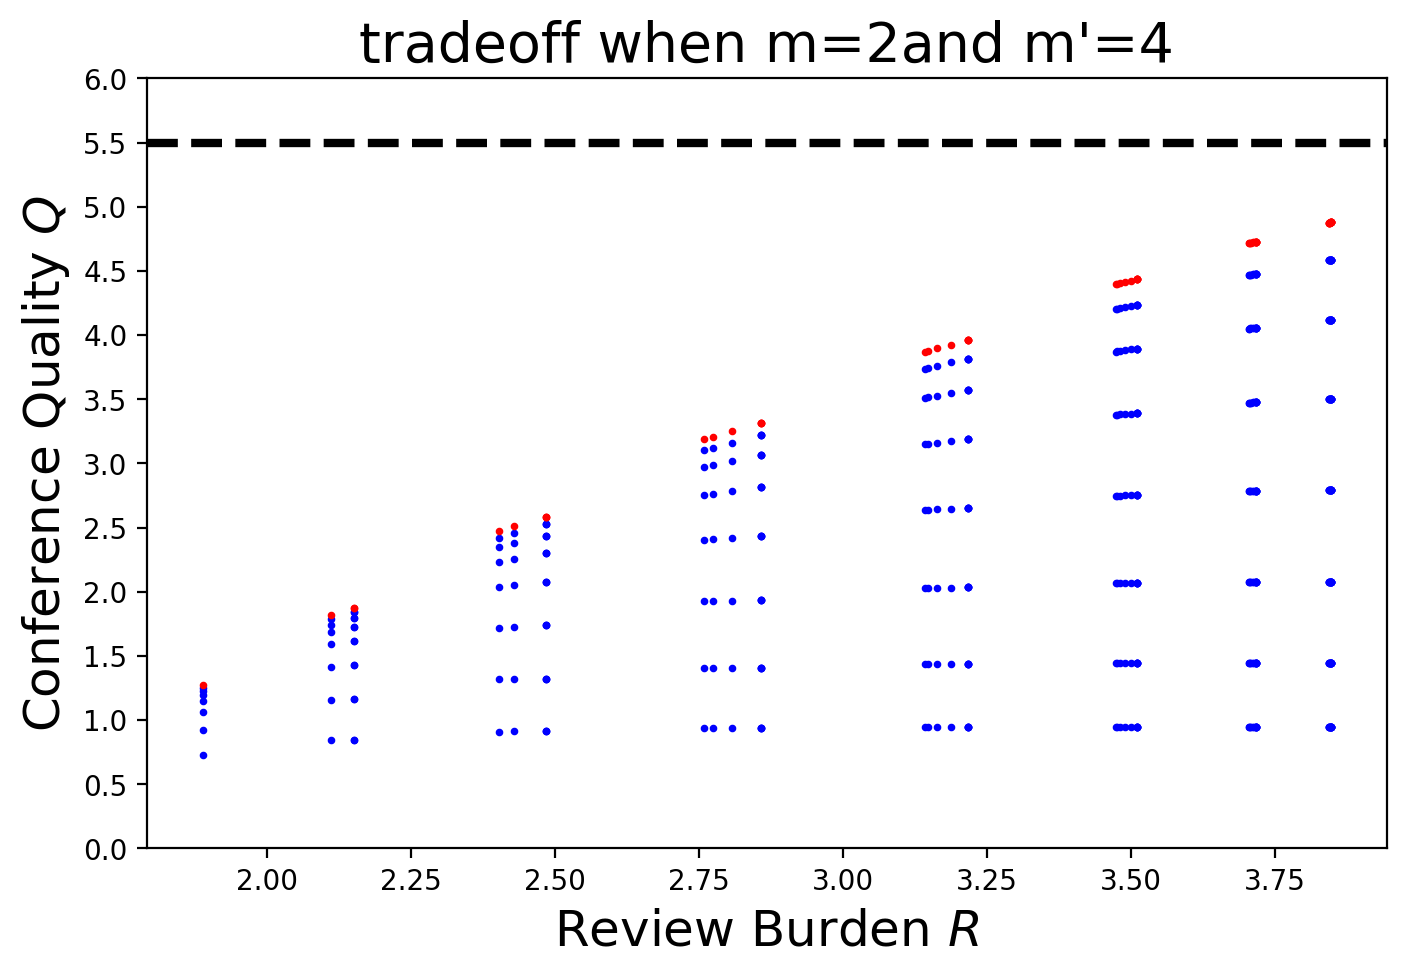

In [236]:
two_phase_experiment_new(2, 4)

0.6442767405485555
0.07463630180578805
4.0 4.0 4.0
4.0 4.0 4.5
4.0 4.0 5.0
4.0 4.0 5.5
4.0 4.0 6.0
4.0 4.0 6.5
4.0 4.0 7.0
4.0 4.0 7.5
4.0 4.4 4.0
4.0 4.4 4.5
4.0 4.4 5.0
4.0 4.4 5.5
4.0 4.4 6.0
4.0 4.4 6.5
4.0 4.4 7.0
4.0 4.4 7.5
4.0 4.800000000000001 4.0
4.0 4.800000000000001 4.5
4.0 4.800000000000001 5.0
4.0 4.800000000000001 5.5
4.0 4.800000000000001 6.0
4.0 4.800000000000001 6.5
4.0 4.800000000000001 7.0
4.0 4.800000000000001 7.5
4.0 5.200000000000001 4.0
4.0 5.200000000000001 4.5
4.0 5.200000000000001 5.0
4.0 5.200000000000001 5.5
4.0 5.200000000000001 6.0
4.0 5.200000000000001 6.5
4.0 5.200000000000001 7.0
4.0 5.200000000000001 7.5
4.0 5.600000000000001 4.0
4.0 5.600000000000001 4.5
4.0 5.600000000000001 5.0
4.0 5.600000000000001 5.5
4.0 5.600000000000001 6.0
4.0 5.600000000000001 6.5
4.0 5.600000000000001 7.0
4.0 5.600000000000001 7.5
4.0 6.000000000000002 4.0
4.0 6.000000000000002 4.5
4.0 6.000000000000002 5.0
4.0 6.000000000000002 5.5
4.0 6.000000000000002 6.0
4.0 6.000000000

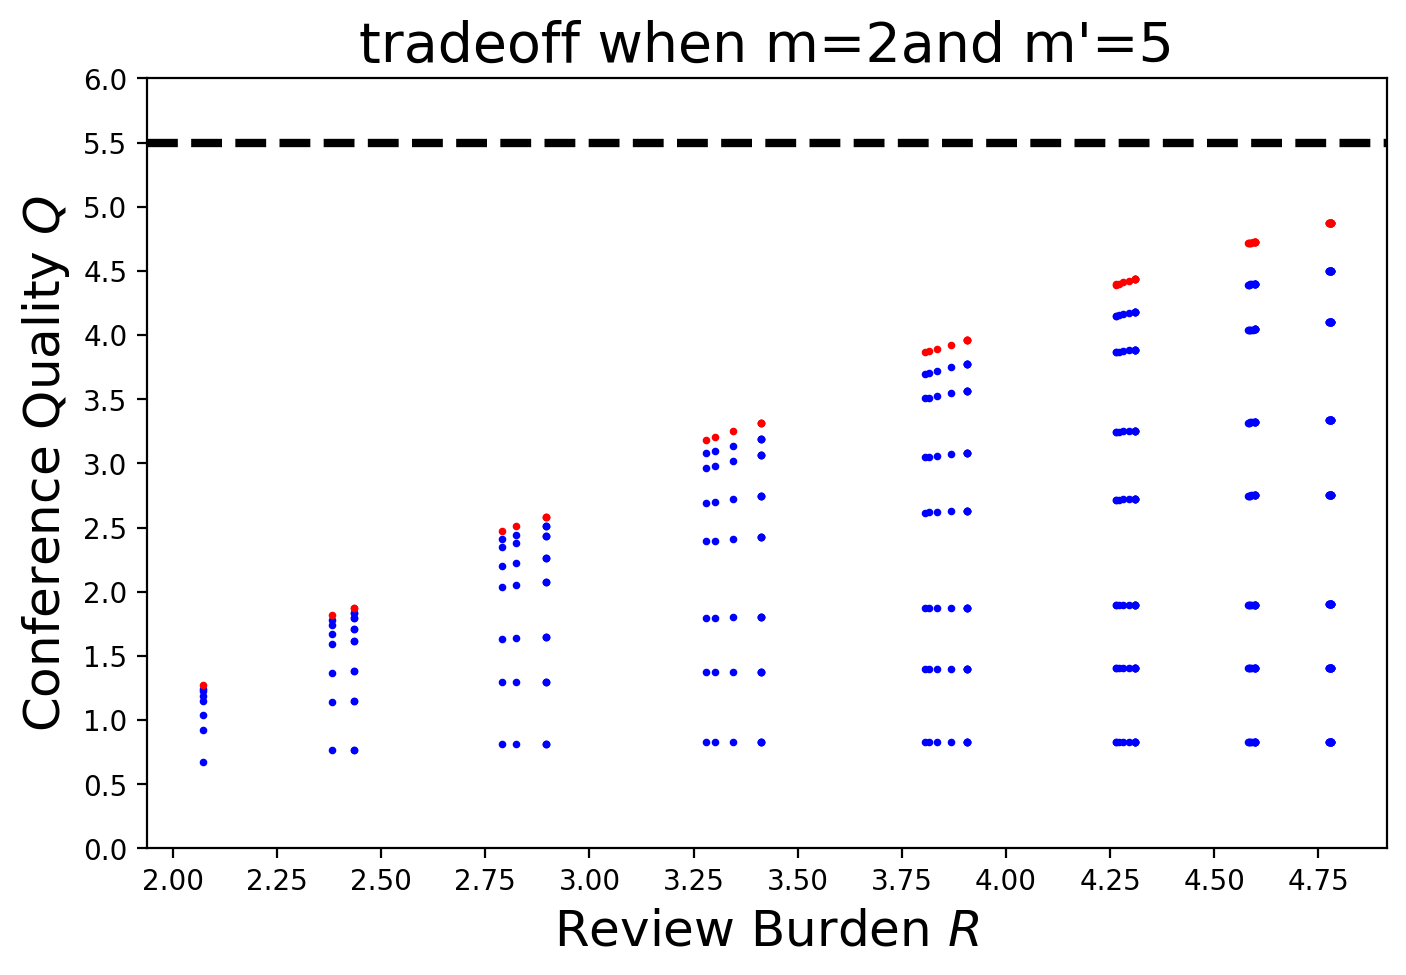

In [237]:
two_phase_experiment_new(2, 5)

0.3430238783951724
0.164887878506987
4.0 4.0 4.0
4.0 4.0 4.5
4.0 4.0 5.0
4.0 4.0 5.5
4.0 4.0 6.0
4.0 4.0 6.5
4.0 4.0 7.0
4.0 4.0 7.5
4.0 4.4 4.0
4.0 4.4 4.5
4.0 4.4 5.0
4.0 4.4 5.5
4.0 4.4 6.0
4.0 4.4 6.5
4.0 4.4 7.0
4.0 4.4 7.5
4.0 4.800000000000001 4.0
4.0 4.800000000000001 4.5
4.0 4.800000000000001 5.0
4.0 4.800000000000001 5.5
4.0 4.800000000000001 6.0
4.0 4.800000000000001 6.5
4.0 4.800000000000001 7.0
4.0 4.800000000000001 7.5
4.0 5.200000000000001 4.0
4.0 5.200000000000001 4.5
4.0 5.200000000000001 5.0
4.0 5.200000000000001 5.5
4.0 5.200000000000001 6.0
4.0 5.200000000000001 6.5
4.0 5.200000000000001 7.0
4.0 5.200000000000001 7.5
4.0 5.600000000000001 4.0
4.0 5.600000000000001 4.5
4.0 5.600000000000001 5.0
4.0 5.600000000000001 5.5
4.0 5.600000000000001 6.0
4.0 5.600000000000001 6.5
4.0 5.600000000000001 7.0
4.0 5.600000000000001 7.5
4.0 6.000000000000002 4.0
4.0 6.000000000000002 4.5
4.0 6.000000000000002 5.0
4.0 6.000000000000002 5.5
4.0 6.000000000000002 6.0
4.0 6.00000000000

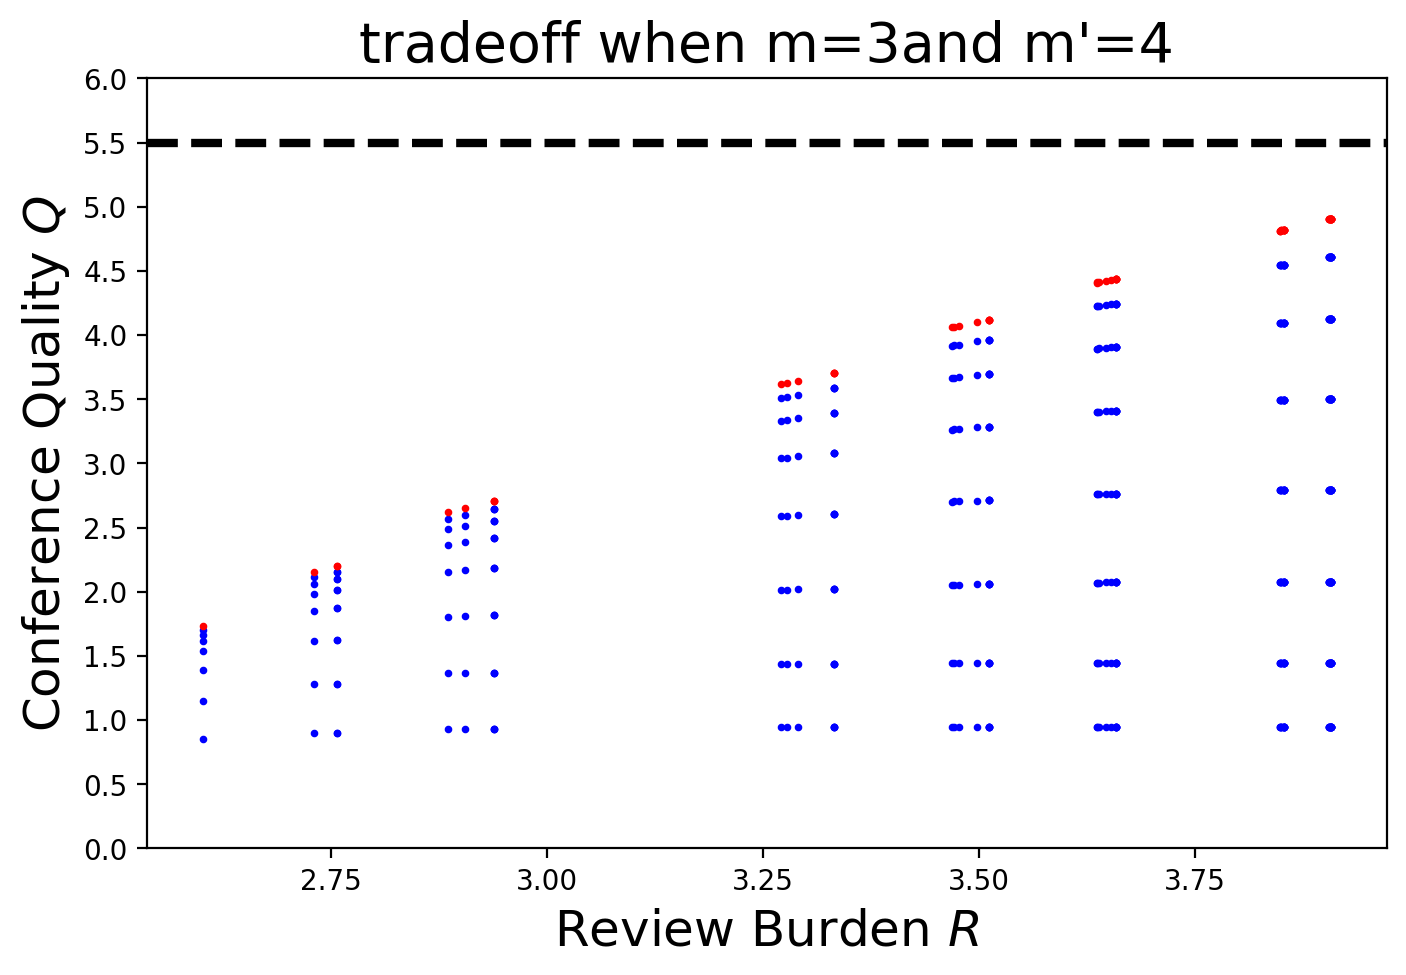

In [238]:
two_phase_experiment_new(3, 4)

0.3430238783951724
0.07463630180578805
4.0 4.0 4.0
4.0 4.0 4.5
4.0 4.0 5.0
4.0 4.0 5.5
4.0 4.0 6.0
4.0 4.0 6.5
4.0 4.0 7.0
4.0 4.0 7.5
4.0 4.4 4.0
4.0 4.4 4.5
4.0 4.4 5.0
4.0 4.4 5.5
4.0 4.4 6.0
4.0 4.4 6.5
4.0 4.4 7.0
4.0 4.4 7.5
4.0 4.800000000000001 4.0
4.0 4.800000000000001 4.5
4.0 4.800000000000001 5.0
4.0 4.800000000000001 5.5
4.0 4.800000000000001 6.0
4.0 4.800000000000001 6.5
4.0 4.800000000000001 7.0
4.0 4.800000000000001 7.5
4.0 5.200000000000001 4.0
4.0 5.200000000000001 4.5
4.0 5.200000000000001 5.0
4.0 5.200000000000001 5.5
4.0 5.200000000000001 6.0
4.0 5.200000000000001 6.5
4.0 5.200000000000001 7.0
4.0 5.200000000000001 7.5
4.0 5.600000000000001 4.0
4.0 5.600000000000001 4.5
4.0 5.600000000000001 5.0
4.0 5.600000000000001 5.5
4.0 5.600000000000001 6.0
4.0 5.600000000000001 6.5
4.0 5.600000000000001 7.0
4.0 5.600000000000001 7.5
4.0 6.000000000000002 4.0
4.0 6.000000000000002 4.5
4.0 6.000000000000002 5.0
4.0 6.000000000000002 5.5
4.0 6.000000000000002 6.0
4.0 6.000000000

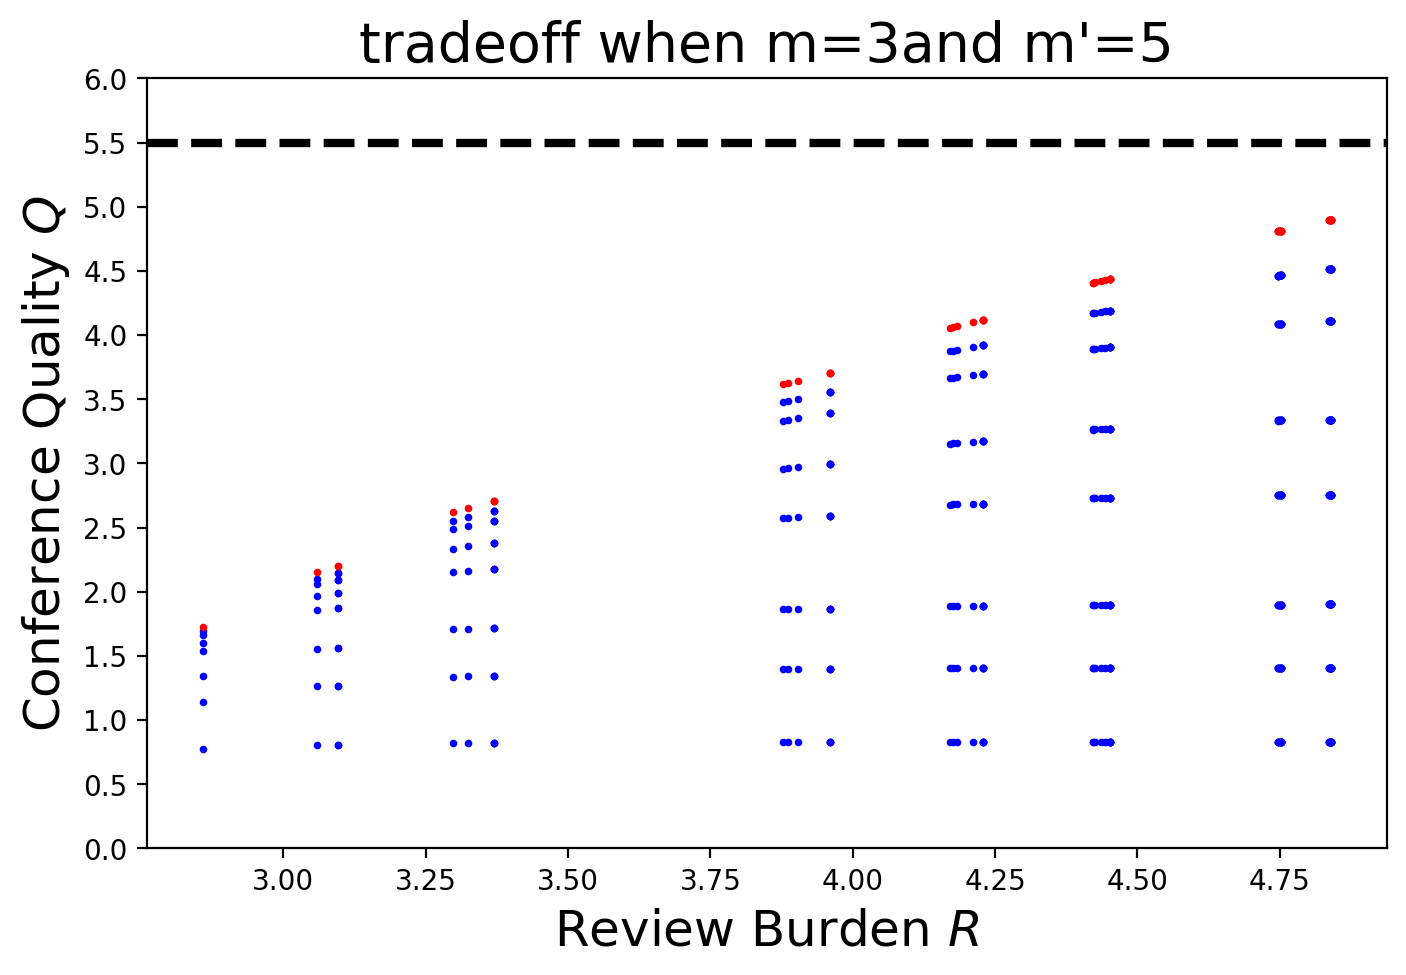

In [239]:
two_phase_experiment_new(3, 5)

0.3430238783951724
0.032577303637953
4.0 4.0 4.0
4.0 4.0 4.5
4.0 4.0 5.0
4.0 4.0 5.5
4.0 4.0 6.0
4.0 4.0 6.5
4.0 4.0 7.0
4.0 4.0 7.5
4.0 4.4 4.0
4.0 4.4 4.5
4.0 4.4 5.0
4.0 4.4 5.5
4.0 4.4 6.0
4.0 4.4 6.5
4.0 4.4 7.0
4.0 4.4 7.5
4.0 4.800000000000001 4.0
4.0 4.800000000000001 4.5
4.0 4.800000000000001 5.0
4.0 4.800000000000001 5.5
4.0 4.800000000000001 6.0
4.0 4.800000000000001 6.5
4.0 4.800000000000001 7.0
4.0 4.800000000000001 7.5
4.0 5.200000000000001 4.0
4.0 5.200000000000001 4.5
4.0 5.200000000000001 5.0
4.0 5.200000000000001 5.5
4.0 5.200000000000001 6.0
4.0 5.200000000000001 6.5
4.0 5.200000000000001 7.0
4.0 5.200000000000001 7.5
4.0 5.600000000000001 4.0
4.0 5.600000000000001 4.5
4.0 5.600000000000001 5.0
4.0 5.600000000000001 5.5
4.0 5.600000000000001 6.0
4.0 5.600000000000001 6.5
4.0 5.600000000000001 7.0
4.0 5.600000000000001 7.5
4.0 6.000000000000002 4.0
4.0 6.000000000000002 4.5
4.0 6.000000000000002 5.0
4.0 6.000000000000002 5.5
4.0 6.000000000000002 6.0
4.0 6.00000000000

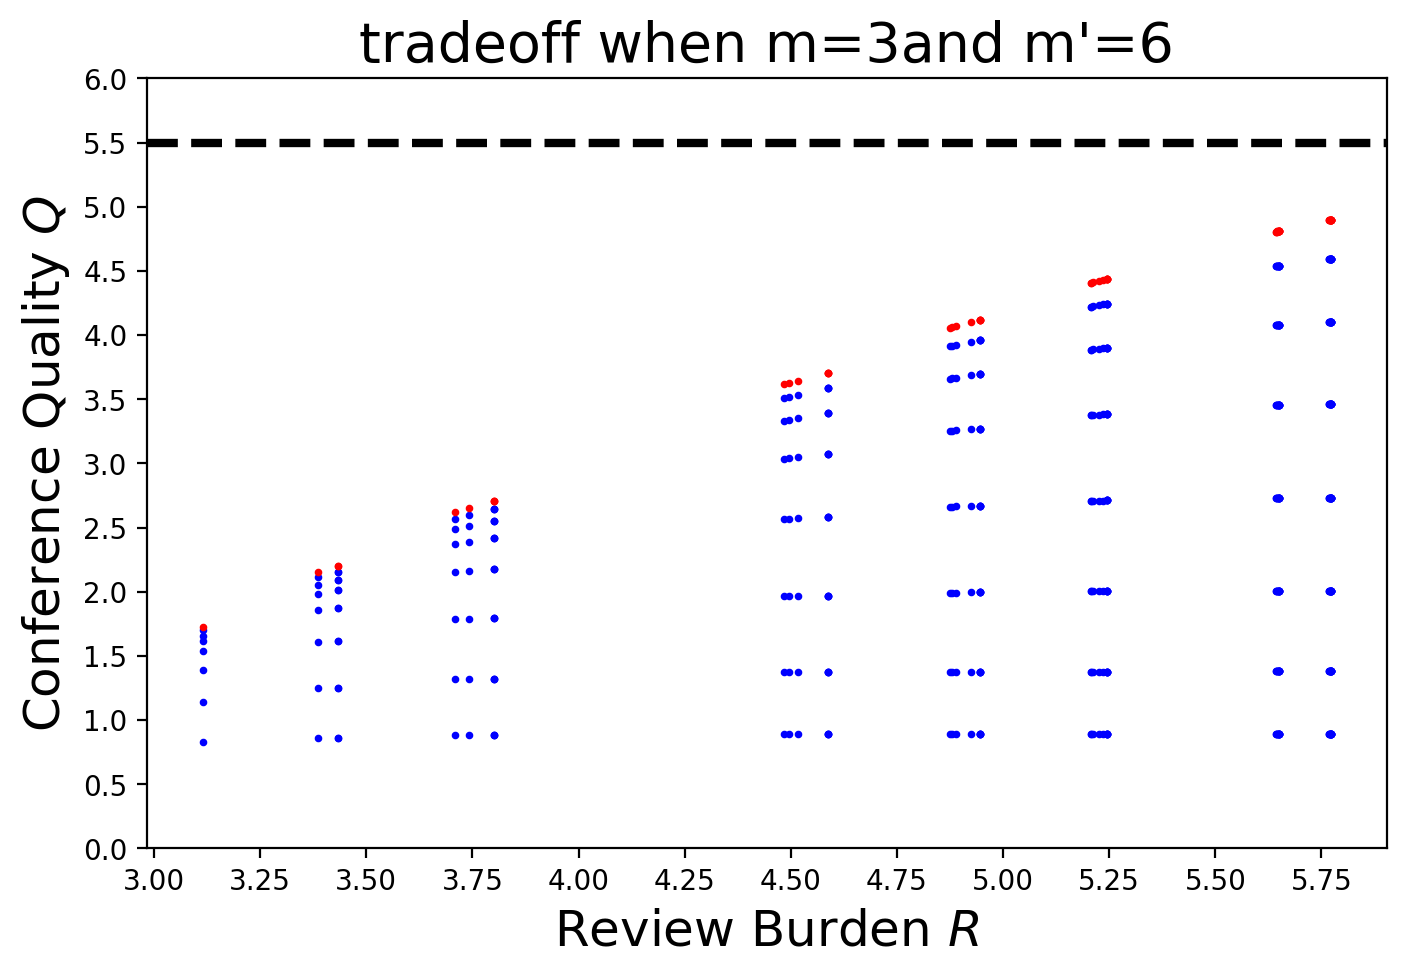

In [240]:
two_phase_experiment_new(3, 6)

In [251]:
two_phase_experiment_new(1, 3)

0.9999994266968336
0.3430238783951724
4.0 4.0 4.0


KeyError: 1